# 3D EFIT Rail Code in MPI

## Combined Zane structure, Eric MPI, My system

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import math
import time
import functools

#from distBox import distBox

import sys
#from mpi4py import MPI
from os import environ 
from typing import *                     
import matplotlib.animation as animation

In [6]:
#MPIComm = Union[MPI.Intracomm, MPI.Intercomm]
#mpi_comm = MPI.COMM_WORLD
#myid = mpi_comm.Get_rank()                                                         
#mpi_size = mpi_comm.Get_size()        
nprocs=1 #mpi_size
myid = 0

# for overlapping slabs:  
# # points per proc along z = npz = gh1/nproc (+2 to ghost boundaries)
# glob_index = loc_index-1 + npz*myid
# loc_index = glob_index - npz*myid + 1
# myid given glob_index = glob_index/npz = ghloc-2

# set Constants
AirCut = False
RailShape = True
figDPI = 600

#Dimmesnsion of simulation space in meters
length1 = 1.5
width1 = 0.1524 # 0.1524
height1 = 0.1524

#Image Folder
imFolder = '/sciclone/scr10/dchendrickson01/EFIT/'
runName = 'RailRubLongg'

#is the rail supported by 0, 1 or 2 ties
Ties = 0
Flaw = False

cycles = 20

#Choose ferquency to be used for excitment
frequency = 49720

#Run for 4 Cycles:
runtime = cycles / frequency 

#Forcing Function Location and type
# 1 for dropped wheel on top
# 2 for rubbing flange on side
# 3 for plane wave
FFunction = 2

#MATERIAL 1 ((steel))
pRatio1 = 0.29                                    #poission's ratio in 
yModulus1 = 200 * (10**9)                           #youngs modulus in pascals
rho1 = 7800                                        #density in kg/m^3

#Image Folder
if FFunction == 1:
    imFolder += 'TopHit/'
elif FFunction == 2:
    imFolder += 'RubTest/'
elif FFunction ==3:
    imFolder += 'Cube/'
elif FFunction ==4:
    imFolder += 'RailDense/'
elif FFunction == 5:
    imFolder += 'RailLong/'
elif FFunction == 6:   #long rail, two wheel rubs
    imFolder += 'Double2.5ma/'

WheelLoad = 173000 #crane force in Neutons

#CALCULATED PARAMETERS FROM INPUTS

mu1 = yModulus1/(2*(1+pRatio1))                    #second Lame Parameter
lmbda1 = 2 * mu1 * pRatio1 / (1 - 2 * pRatio1)     #first Lame Parameter

#Calculate speed of longitudinal and transverse waves in material 1
cl1 = np.sqrt((lmbda1 + 2* mu1)/rho1)
ct1 = np.sqrt(mu1/rho1)

#calculate wave lengths for material 1
omegaL1 = cl1 / frequency
omegaT1 = ct1 / frequency

In [7]:
#Set time step and grid step to be 10 steps per frequency and ten steps per wavelength respectively
#ts = 1 / frequency / 10    #time step
gs = (min(omegaL1, omegaT1) /13)    #grid step
ts = gs/((max(cl1,ct1))*(np.sqrt(3)))*0.93 #time step

frequency = 16300

#Run for 4 Cycles:
runtime = cycles / frequency 

Tsteps = int(math.ceil(runtime / ts)) + 1       #total Time Steps

#number of grid points
gl1 = int(math.ceil(length1 / gs)) +1       #length 
gw1 = int(math.ceil(width1 / gs)) +1       #width
gh1 = int(math.ceil(height1 / gs)) +1       #height

print(gs, ts, gl1, gw1, gh1, Tsteps, cl1, ct1)

0.004877343816768354 4.5178137402466586e-07 309 33 33 2717 5796.653896162343 3152.519949406393


In [4]:
# Keep these as the global values
xmax=gl1-1
ymax=gw1-1
zmax=gh1-1

#due to double think BCs, adding one, but keeping the maxes
#gw1+=1
#gh1+=1

In [5]:
#####

#MPI EJW Section 1
#extend the length of the beam so that the number of nodes in the x dimmension 
#is the evenly divisible by the number of processors
if (gl1 % nprocs) != 0:
    gl1 += nprocs - (gl1 % nprocs)

#check you did it right
if (gl1 % nprocs) != 0:
    if myid == 0:
        print("Hey, gl1 not divisible by nproc",gl1,nprocs)
        sys.exit()
npx=int(gl1/nprocs)


if myid == 0:
    print("gl1,npx,nproc",gl1,npx,nprocs)

#print(runtime, ts, gs, Tsteps, gl, gh)

if myid == 0:
    print('runtime (s), time step size (s), total # of time steps:', runtime, ts, Tsteps)
    print('grid step size, # of length pts, # of height pts, # of width pts, gl1 loc pts:', gs,gl1,gw1,gh1,npx)

#tensor to store material properties for each point
#0 index is density
#1 index is first Lame Parmaeter
#2 index is second lame parameter

#MPI EJW Section 2 changes
matDensity=np.zeros((gl1,gw1,gh1))
matLambda=np.zeros((gl1,gw1,gh1))
matMu=np.zeros((gl1,gw1,gh1))
matBCs=np.zeros((gl1,gw1,gh1))
signalLocation=np.zeros((gl1,gw1,gh1))

matDensity[:,:,:]=rho1
matLambda[:,:,:]=lmbda1
matMu[:,:,:]=mu1
matBCs[:,:,:]=0

gl1,npx,nproc 309 309 1
runtime (s), time step size (s), total # of time steps: 0.00030674846625766873 4.5178137402466586e-07 680
grid step size, # of length pts, # of height pts, # of width pts, gl1 loc pts: 0.004877343816768354 309 33 33 309


In [6]:
## for latter rail section, define the dimmmensions in terms of grid
HeadThickness = 0.05
WebThickness = 0.035
FootThickness = 0.03
HeadWidth = 0.102

relHeadThick = HeadThickness / height1
relWeb = WebThickness / width1
relFoot = FootThickness / height1
relHeadWidth = HeadWidth / width1

relStartHeadThick = 1 - relHeadThick
relStartWeb = 0.5 - (relWeb / 2.0)
relEndWeb = 0.5 + (relWeb / 2.0)
relStartHeadWidth = 0.5 - (relHeadWidth / 2.0)
relEndHeadWidth = 0.5 + (relHeadWidth / 2.0)


gridStartHead = round(gh1 * relStartHeadThick)
gridStartWeb = round(gw1 * relStartWeb)
gridEndWeb = round(gw1 * relEndWeb)
gridEndFoot = round(gh1 * relFoot)
gridStartHeadWidth = round(gw1 * relStartHeadWidth)
gridEndHeadWidth = round(gw1  * relEndHeadWidth)



In [9]:
whlayer = 0.001

#Make the Signal Location grid
if FFunction == 1:
    pnodes = int(whlayer / 2)
    contactLength = int(0.001 / gs)  #1 cm contact patch

    signalLocation[0:contactLength,gridStartHeadWidth:gridEndHeadWidth, -3:] = 1
    
elif FFunction == 2:
    pnodes = int(whlayer / 4)
    contactLength = max(int(0.004 / gs),3)  #4 cm contact patch

    signalLocation[0:contactLength,gridStartHeadWidth:gridStartHeadWidth+3, gridStartHead:] = 1
    print(FFunction, contactLength, np.sum(signalLocation))

    ## Find the share of the force per node for FF1
    
elif FFunction ==3:
    '''signalLocation[3:4,2:ymax-1,2:zmax-1] = 1
    signalLocation[3:4,2:ymax-1,2:zmax-1] = 1
    signalLocation[2:3,2:ymax-1,2:zmax-1] = 0.5
    signalLocation[4:5,2:ymax-1,2:zmax-1] = 0.5
    '''
    signalLocation[13:15,:,:] = 1
    signalLocation[12:13,:,:] = 0.5
    signalLocation[15:16,:,:] = 0.5
    
    
elif FFunction == 4:

    signalLocation[int(gl1/2)-5:int(gl1/2)+5,int(gw1/2)-5:int(gw1/2)+5,zmax-2] = 1
    signalLocation[int(gl1/2)-5:int(gl1/2)+5,int(gw1/2)-5:int(gw1/2)+5,zmax-1] = 0.5
    signalLocation[int(gl1/2)-5:int(gl1/2)+5,int(gw1/2)-5:int(gw1/2)+5,zmax-3] = 0.5
    

elif FFunction == 5:

    signalLocation[int(gl1/2)-5:int(gl1/2)+5,int(gw1/2)-5:int(gw1/2)+5,zmax-2] = 1
    signalLocation[int(gl1/2)-5:int(gl1/2)+5,int(gw1/2)-5:int(gw1/2)+5,zmax-1] = 0.5
    signalLocation[int(gl1/2)-5:int(gl1/2)+5,int(gw1/2)-5:int(gw1/2)+5,zmax-3] = 0.5
    

elif FFunction == 6:
    
    Wheel1Distance = 0.5 # wheel starts 1 meter down track
    Wheel1Start = int(Wheel1Distance / gs)
    
    signalLocation[Wheel1Start:Wheel1Start+6,gridStartHeadWidth:gridStartHeadWidth+2,gridStartHead:zmax-2] = 1

    signalLocation[Wheel1Start+6,gridStartHeadWidth:gridStartHeadWidth+2,gridStartHead:zmax-2] = 0.5
    signalLocation[Wheel1Start-1,gridStartHeadWidth:gridStartHeadWidth+2,gridStartHead:zmax-2] = 0.5
    signalLocation[Wheel1Start:Wheel1Start+6,gridStartHeadWidth+2:gridStartHeadWidth+3,gridStartHead:zmax-2] = 0.5

    sep = int(1.360/gs) # Wheel 2 is centered 1.36 meters from wheel 1
    
    signalLocation[Wheel1Start+sep:Wheel1Start+6+sep,gridEndHeadWidth-2:gridEndHeadWidth,gridStartHead:zmax-2] = 1

    signalLocation[Wheel1Start+6+sep,gridEndHeadWidth-2:gridEndHeadWidth,gridStartHead:zmax-2] = 0.5
    signalLocation[Wheel1Start-1+sep,gridEndHeadWidth-2:gridEndHeadWidth,gridStartHead:zmax-2] = 0.5
    signalLocation[Wheel1Start+sep:Wheel1Start+6+sep,gridEndHeadWidth-3:gridEndHeadWidth-2,gridStartHead:zmax-2] = 0.5
    
    
specificWheelLoad = WheelLoad / np.sum(signalLocation)


if myid == 0:
    print('globs made, line 145')

2 3 99.0
globs made, line 145


In [10]:
#########
# FUnctions
def JBSU(x,y,z):
    try:
        if (matBCs[x,y,z] == 2 or matBCs[x-1,y,z] == 2 or matBCs[x,y-1,z] == 2 or matBCs[x,y,z-1] == 2):
            pass
        else:
            norm1=(1/gs)*(matLambda[x,y,z]+2*matMu[x,y,z])
            norm2=(1/gs)*(matLambda[x,y,z])

            ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
            sxx[x,y,z]=sxx[x,y,z]+ds*ts

            ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
            syy[x,y,z]=syy[x,y,z]+ds*ts

            ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
            szz[x,y,z]=szz[x,y,z]+ds*ts

        if (matBCs[x,y,z] == 2 or matBCs[x+1,y,z] == 2 or matBCs[x-1,y,z] == 2 or matBCs[x,y+1,z] == 2 
            or matBCs[x,y-1,z] == 2 or matBCs[x,y,z-1] == 2 or matBCs[x+1,y+1,z] == 2):
            pass
        else:
            shearDenomxy=(1/matMu[x,y,z])+(1/matMu[x+1,y,z])+(1/matMu[x,y+1,z])+(1/matMu[x+1,y+1,z])
            shearxy=4*(1/gs)*(1/shearDenomxy)
            ds=shearxy*(vx[x,y+1,z]-vx[x,y,z]+vy[x+1,y,z]-vy[x,y,z])
            sxy[x,y,z]=sxy[x,y,z]+ds*ts

        if (matBCs[x,y,z] == 2 or matBCs[x+1,y,z] == 2 or matBCs[x-1,y,z] == 2 or matBCs[x,y,z+1] == 2 
            or matBCs[x,y,z-1] == 2 or matBCs[x,y-1,z] == 2 or matBCs[x+1,y,z+1] == 2):
            pass
        else:
            shearDenomxz=(1/matMu[x,y,z])+(1/matMu[x+1,y,z])+(1/matMu[x,y,z+1])+(1/matMu[x+1,y,z+1])
            shearxz=4*(1/gs)*(1/shearDenomxz)
            ds=shearxz*(vx[x,y,z+1]-vx[x,y,z]+vz[x+1,y,z]-vz[x,y,z])
            sxz[x,y,z]=sxz[x,y,z]+ds*ts   

        if (matBCs[x,y,z] == 2 or matBCs[x,y,z+1] == 2 or matBCs[x,y,z-1] == 2 or matBCs[x,y+1,z] == 2 
            or matBCs[x,y-1,z] == 2 or matBCs[x-1,y,z] == 2 or matBCs[x,y+1,z+1] == 2):
            pass
        else:
            shearDenomyz=(1/matMu[x,y,z])+(1/matMu[x,y+1,z])+(1/matMu[x,y,z+1])+(1/matMu[x,y+1,z+1])
            shearyz=4*(1/gs)*(1/shearDenomyz)
            ds=shearyz*(vy[x,y,z+1]-vy[x,y,z]+vz[x,y+1,z]-vz[x,y,z])
            syz[x,y,z]=syz[x,y,z]+ds*ts
    except:
        print('Unrecognized BC stress', matBCs[x,y,z],x,y,z)


In [11]:
# %%
def JBUV(x,y,z):
    
    if matBCs[x,y,z] == 0: 
        dvxConst=2*(1/gs)*(1/(matDensity[x,y,z]+matDensity[x+1,y,z]))
        dv=dvxConst*( sxx[x+1,y,z]-sxx[x,y,z]
                     +sxy[x,y,z]-sxy[x,y-1,z]
                     +sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts
    #x at 0
    elif (matBCs[x,y,z] ==2 or matBCs[x,y-1,z]==2 or matBCs[x,y,z-2]==2):
        pass #requires elements out of the direction
    elif matBCs[x+1,y,z] == 2:
        vx[x,y,z] += 2 * ts/gs * 1/(2 * matDensity[x,y,z]) * ((-2)*sxx[x,y,z])

    elif matBCs[x-1,y,z] ==2 :
        vx[x,y,z] += 2 * ts/gs * 1/(2 * matDensity[x,y,z]) * ((2)*sxx[x+1,y,z])

    else:
        dvxConst=2*(1/gs)*(1/(matDensity[x,y,z]+matDensity[x+1,y,z]))
        dv=dvxConst*( sxx[x+1,y,z]-sxx[x,y,z]
                     +sxy[x,y,z]-sxy[x,y-1,z]
                     +sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts
    
    #Vy cases
    if matBCs[x,y,z] == 0: 
        dvyConst=2*(1/gs)*(1/(matDensity[x,y,z]+matDensity[x,y+1,z]))
        dv=dvyConst* ( sxy[x,y,z]-sxy[x-1,y,z]
                      +syy[x,y+1,z]-syy[x,y,z]
                      +syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts
    #y = 0
    elif (matBCs[x,y,z] ==2 or matBCs[x-1,y,z] == 2 or matBCs[x,y,z-1] == 2):
        pass  #requires elements out of the direction
    elif matBCs[x,y+1,z] == 2:
        vy[x,y,z] += 2 * ts/gs * 1/(2 * matDensity[x,y,z]) * ((-2)*syy[x,y,z])
    elif matBCs[x,y-1,z] == 2:
        vy[x,y,z] += 2 * ts/gs * 1/(2 * matDensity[x,y,z]) * ((2)*syy[x,y+1,z])
    else:
        dvyConst=2*(1/gs)*(1/(matDensity[x,y,z]+matDensity[x,y+1,z]))
        dv=dvyConst* ( sxy[x,y,z]-sxy[x-1,y,z]
                      +syy[x,y+1,z]-syy[x,y,z]
                      +syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

    #Vz cases
    if matBCs[x,y,z] ==0:
        dvzConst=2*(1/gs)*(1/(matDensity[x,y,z]+matDensity[x,y,z+1]))
        dv=dvzConst*( sxz[x,y,z]-sxz[x-1,y,z]
                     +syz[x,y,z]-syz[x,y-1,z]
                     +szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts
    #z at 0
    elif (matBCs[x,y,z] == 2 or matBCs[x-1,y,z] == 2 or matBCs[x,y-1,z]==2):
        pass
    elif matBCs[x,y,z+1] == 2:
        vz[x,y,z] += 2 * ts/gs *(1/(2 * matDensity[x,y,z])) * ((-2)*szz[x,y,z])
    elif matBCs[z,y,z-1] == 2:
        vz[x,y,z] += 2 * ts/gs *(1/(2 * matDensity[x,y,z])) * ((2)*szz[x,y,z+1])
    else:
        dvzConst=2*(1/gs)*(1/(matDensity[x,y,z]+matDensity[x,y,z+1]))
        dv=dvzConst*( sxz[x,y,z]-sxz[x-1,y,z]
                     +syz[x,y,z]-syz[x,y-1,z]
                     +szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts


def setSimSpaceBC99(matBCs):
    
    matBCs[0,:,:]=99
    matBCs[xmax,:,:]=99
    matBCs[:,0,:]=99
    matBCs[:,ymax,:]=99
    matBCs[:,:,0]=99
    matBCs[:,:,zmax]=99
    
    return matBCs


In [12]:
def setSimSpaceBCs(matBCs):
    #Second Dimmension boundaries /y
    matBCs[:,0,:]=2
    matBCs[:,1,:]=1
    matBCs[:,ymax,:]=2
    matBCs[:,ymax-1,:]=2
    matBCs[:,ymax-2,:]=1

    #Third Dimmension Boundaries /z
    matBCs[:,:,0]=2
    matBCs[:,2:ymax-1,1]=1
    matBCs[:,:,zmax]=2
    matBCs[:,:,zmax-1]=2
    matBCs[:,2:ymax-1,zmax-2]=1
    
    #First Dimmension Boundaries /x
    #   handled different if this is going to be calculated by node
    #   others c does it different, but they split between nodes before calculating
    #   here we calculate the whole set and then parse
    matBCs[0,:,:]=2
    matBCs[1,2:ymax-1,1:zmax-1]=1
    matBCs[xmax,:,:]=2
    matBCs[xmax-1,:,:]=2
    matBCs[xmax-2,1:ymax-1,1:zmax-1]=1
    
    return matBCs
    

In [13]:
def MakeFlaw(matBCs):
    MidPoint = int(gl1/2)
    StartTrans = int(gl1/5)*2
    EndTrans = int(gl1/5)*3
    
    TransToEnd = gl1-EndTrans
    MidTransToEnd = int(TransToEnd/2)+EndTrans
    QuarterTrans = int((EndTrans-StartTrans)/4)
    
    StartFlawX = MidTransToEnd - QuarterTrans
    EndFlawX = MidTransToEnd + QuarterTrans
    
    StartFlawY = MidPoint - QuarterTrans
    EndFlawY = MidPoint + QuarterTrans
    
    VertFlaw = int(gh1/8)
    VertStart = zmax - VertFlaw
    
    #main hole
    matBCs[StartFlawX:EndFlawX,StartFlawY:EndFlawY,VertStart:] = 2
    
    #edges
    matBCs[StartFlawX:EndFlawX,StartFlawY:EndFlawY,VertStart-1] = 1
    matBCs[StartFlawX-1,StartFlawY-1:EndFlawY+1,VertStart:zmax-2]=1
    matBCs[EndFlawX+1,StartFlawY-1:EndFlawY+1,VertStart:zmax-2]=1
    matBCs[StartFlawX-1:EndFlawX+1,StartFlawY-1,VertStart:zmax-2]=1
    matBCs[StartFlawX-1:EndFlawX+1,EndFlawY+1,VertStart:zmax-2]=1
    
    return matBCs
    

In [14]:
def setRailBCs(matBCs):
    #set the boundary conditions in material props4
    # Set the simulations pace boundarys
    # top
    
    #top of footing
    matBCs[:,:gridStartWeb,gridEndFoot]=1
    matBCs[:,ymax-gridStartWeb:,gridEndFoot]=1

    #sides of web
    matBCs[:,gridStartWeb,gridStartHead:gridEndFoot]=1
    matBCs[:,gridEndWeb,gridStartHead:gridEndFoot]=1

    #bottom of head
    matBCs[:,gridStartHeadWidth:gridStartWeb,gridStartHead]=1
    matBCs[:,gridEndWeb:gridEndHeadWidth,gridStartHead]=1

    #sides of head
    matBCs[:,gridStartHeadWidth,gridStartHead:]=1
    matBCs[:,gridEndHeadWidth,gridStartHead:]=1

    #zone 1 of air, left of web
    matBCs[:,:gridStartWeb,gridEndFoot:gridStartHead]=2
    # zone 2 of air left of head
    matBCs[:,:gridStartHeadWidth,:gridStartHead]=2
    # zone 3 of air, right of web
    matBCs[:,gridEndWeb:,gridEndFoot:gridStartHead]=2
    # zone 4 of air, right of head
    matBCs[:,gridEndHeadWidth:,gridStartHead:]=2

    
    return matBCs
    

In [15]:
#matBCs = setSimSpaceBC99(matBCs)
matBCs = setSimSpaceBCs(matBCs)
    
if RailShape:
    #matDensity,matLambda,matMu = setAirCut(matDensity,matLambda,matMu)
    matBCs = setRailBCs(matBCs)
    #matBCs = addTies(matBCs,Ties)

#Add Flaw
#    136 x 136 x15
if Flaw:
    matBCs = MakeFlaw(matBCs)


In [16]:
print(matBCs[9,:,:])

[[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 1. 2. 2.]
 [2. 2. 2. ... 1. 2. 2.]
 ...
 [2. 1. 1. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]]


air cuts made, line 310
line 369: glb inputx, local inputx id, local inputx:   2 0 3


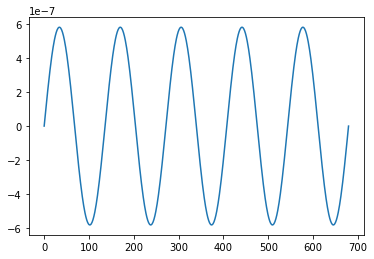

In [17]:
if myid == 0:
    print('air cuts made, line 310')

#define sine-exponential wave excitation

timeVec=np.linspace(0,runtime,Tsteps)

#MPI EJW Section #3 changes
#radius
r=3
inputx=2
inputy=int(gw1/2)
inputz=int(gh1/2)

# get loc by formula

inputid=int(inputx / npx)
inputlocx=int(inputx - inputid*npx+1)

if (myid == 0) :
    print("line 369: glb inputx, local inputx id, local inputx:  ",inputx,inputid,inputlocx)


szzConst=2*ts/(gs*rho1)

amp=10000
decayRate= 0
sinConst=ts*amp/rho1

sinInputSignal=sinConst*np.sin(2*np.pi*frequency*timeVec)*np.exp(-decayRate*timeVec)
#sinInputSignal-=0.0000001
#sinInputSignal[int(1/12*Tsteps):]=0

fig = plt.figure()
plt.plot(sinInputSignal)
plt.show()

In [18]:
# MPI EJW Section #4 changes 

#initialize fields
vx=np.zeros((npx,gw1,gh1))
vy=np.zeros((npx,gw1,gh1))
vz=np.zeros((npx,gw1,gh1))

sxx=np.zeros((npx,gw1,gh1))
syy=np.zeros((npx,gw1,gh1))
szz=np.zeros((npx,gw1,gh1))
sxy=np.zeros((npx,gw1,gh1))
sxz=np.zeros((npx,gw1,gh1))
syz=np.zeros((npx,gw1,gh1))

#record the signal at a specified location
### ADD map function for this
signalLocx=int(gl1/2)
signalLocy=int(gw1/2)
signalLocz=int(gh1/2)

vxSignal=np.zeros(Tsteps)
vySignal=np.zeros(Tsteps)
vzSignal=np.zeros(Tsteps)

In [19]:

#record the signal at a specified location
### ADD map function for this
#SAME AS INPUTZ?

#manually setting x for long where wave may not propaagate full lengthh in time

FSignalLocX= 5 #int(gl1/4)
BSignalLocX=25 # int(3*gl1/4)
USignalLocX=10 #int(gl1/4)
DSignalLocX=10 #int(gl1/4)
RSignalLocX=10 #int(gl1/4)
LSignalLocX=10 #int(gl1/4)
MSignalLocX=10 #int(gl1/4)

FSignalLocY=int(gw1/2)
BSignalLocY=int(gw1/2)
USignalLocY=int(gw1/2)
DSignalLocY=int(gw1/2)
RSignalLocY=int(gw1/4)
LSignalLocY=int(3*gw1/4)
MSignalLocY=int(gw1/2)

FSignalLocZ=int(gh1/2)
BSignalLocZ=int(gh1/2)
USignalLocZ=int(3*gh1/4)
DSignalLocZ=int(gh1/4)
RSignalLocZ=int(gh1/2)
LSignalLocZ=int(gh1/2)
MSignalLocZ=int(gh1/2)


#signal locations going to be a quarter of the way in the middle from the 
# Front, Back, Up side, Down side, Right, Left, and Middle Middle Middle
FSignal=np.zeros((Tsteps,3))
BSignal=np.zeros((Tsteps,3))
USignal=np.zeros((Tsteps,3))
DSignal=np.zeros((Tsteps,3))
RSignal=np.zeros((Tsteps,3))
LSignal=np.zeros((Tsteps,3))
MSignal=np.zeros((Tsteps,3))

In [20]:
signalloc = np.zeros((npx,gw1,gh1))
signalloc=signalLocation[:,:,:]

stime = time.time()

In [21]:
# asdfasdf
MidMatrixX = np.zeros((gl1,Tsteps))
MidMatrixY = np.zeros((gl1,Tsteps))
MidMatrixZ = np.zeros((gl1,Tsteps))

Movements = np.zeros((gl1,gw1,gh1,Tsteps))
DisX = np.zeros((gl1,gw1,gh1))
DisY = np.zeros((gl1,gw1,gh1))
DisZ = np.zeros((gl1,gw1,gh1))


In [22]:
for t in range(Tsteps):
     
    if FFunction == 2:
        vz += signalloc * sinInputSignal[t]
        print(np.sum(vz))
    
    if FFunction ==3:
        vx += signalloc * sinInputSignal[t]

    if FFunction == 4:
        vz += signalloc * sinInputSignal[t]

    for x in range(0,xmax):
        for y in range(0,ymax):
            for z in range(0,zmax):
                JBSU(x,y,z)

    
    # cut boundaries off of arrays
    '''Remove for Jupyter single processor
    sxxt=sxx[1:npx+1,:,:]
    syyt=syy[1:npx+1,:,:]
    szzt=szz[1:npx+1,:,:]
    sxyt=sxy[1:npx+1,:,:]
    sxzt=sxz[1:npx+1,:,:]
    syzt=syz[1:npx+1,:,:]

    # redistrubute ghost/boundary values
    sxx=distBox(sxxt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    syy=distBox(syyt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    szz=distBox(szzt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    sxy=distBox(sxyt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    sxz=distBox(sxzt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    syz=distBox(syzt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    '''
    
    #if the forcing function is a stress
    if FFunction == 1:
        szz -= signalloc * specificWheelLoad

    for x in range(0,xmax):
        for y in range(0,ymax):
            for z in range(0,zmax):
                JBUV(x,y,z)

    MidMatrixX[:,t] = vx[:,MSignalLocY,MSignalLocZ]
    MidMatrixY[:,t] = vy[:,MSignalLocY,MSignalLocZ]
    MidMatrixZ[:,t] = vz[:,MSignalLocY,MSignalLocZ]
    
    vxg=vx #[1:npx+1,:,:]        
    vyg=vy#[1:npx+1,:,:]        
    vzg=vz#[1:npx+1,:,:]        

    
    if (myid == 0 ) :
        USignal[t]=[vxg[USignalLocX,USignalLocY,USignalLocZ],vyg[USignalLocX,USignalLocY,USignalLocZ],vzg[USignalLocX,USignalLocY,USignalLocZ]]
        DSignal[t]=[vxg[DSignalLocX,DSignalLocY,DSignalLocZ],vyg[DSignalLocX,DSignalLocY,DSignalLocZ],vzg[DSignalLocX,DSignalLocY,DSignalLocZ]]
        RSignal[t]=[vxg[RSignalLocX,RSignalLocY,RSignalLocZ],vyg[RSignalLocX,RSignalLocY,RSignalLocZ],vzg[RSignalLocX,RSignalLocY,RSignalLocZ]]
        LSignal[t]=[vxg[LSignalLocX,LSignalLocY,LSignalLocZ],vyg[LSignalLocX,LSignalLocY,LSignalLocZ],vzg[LSignalLocX,LSignalLocY,LSignalLocZ]]
        MSignal[t]=[vxg[MSignalLocX,MSignalLocY,MSignalLocZ],vyg[MSignalLocX,MSignalLocY,MSignalLocZ],vzg[MSignalLocX,MSignalLocY,MSignalLocZ]]
        FSignal[t]=[vxg[FSignalLocX,FSignalLocY,FSignalLocZ],vyg[FSignalLocX,FSignalLocY,FSignalLocZ],vzg[FSignalLocX,FSignalLocY,FSignalLocZ]]
        BSignal[t]=[vxg[BSignalLocX,BSignalLocY,BSignalLocZ],vyg[BSignalLocX,BSignalLocY,BSignalLocZ],vzg[BSignalLocX,BSignalLocY,BSignalLocZ]]
        
        DisX += vx[:,:,:] * ts
        DisY += vy[:,:,:] * ts
        DisZ += vz[:,:,:] * ts
        Movements[:,:,:,t] = np.sqrt(DisX**2 + DisY**2 + DisZ**2)
        
        if t%5==0:
        
            fig=plt.figure()
            plt.contourf(np.transpose(vxg[:,:,int(gh1/2)]), cmap='seismic')
            plt.savefig(imFolder+'Mid/vyMidHeightShear'+str(t).zfill(5)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)
            
            fig=plt.figure()
            plt.contourf(np.transpose(vxg[:,int(gw1/2),:]), cmap='seismic')
            plt.savefig(imFolder + 'Vert/vyVertShear'+str(t).zfill(5)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)    
            
            fig=plt.figure()
            plt.contourf(np.transpose(vxg[int(gl1/2),:,:]), cmap='seismic')
            plt.savefig(imFolder + 'Head/vyMidLenShear'+str(t).zfill(5)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)  
    
            fig=plt.figure()
            plt.contourf(np.transpose(vxg[:,:,int(gh1/4)]), cmap='seismic')
            plt.savefig(imFolder+'zplane25/vy25Shear'+str(t).zfill(5)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)
            
            fig=plt.figure()
            plt.contourf(np.transpose(vxg[:,:,int(3*gh1/4)]), cmap='seismic')
            plt.savefig(imFolder+'zplane75/vy75Shear'+str(t).zfill(5)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)
            '''
            fig=plt.figure()
            plt.contourf(np.transpose(Movements[:,:,zmax-1,t]), cmap='seismic')
            plt.savefig(imFolder+'TopSurface/TopSurface'+str(t).zfill(5)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)
            
            fig=plt.figure()
            plt.contourf(np.transpose(Movements[3:,ymax,:,t]), cmap='seismic')
            plt.savefig(imFolder+'RightSurface/RightSurface'+str(t).zfill(5)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)
            
            fig=plt.figure()
            plt.contourf(np.transpose(Movements[3:,0,:,t]), cmap='seismic')
            plt.savefig(imFolder+'LeftSurface/LeftSurface'+str(t).zfill(5)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)
            '''

    # Collect vx, sxx checksum contributions for printing
    vxt=vx[1:npx+1,:,:]
    sxxt=sxx[1:npx+1,:,:]

    #ckvs=np.array(0.0,'d')
    #ckss=np.array(0.0,'d')
    
    ckv=np.sum(np.absolute(vxg))
    cks=np.sum(np.absolute(sxx))
    #mpi_comm.Reduce(ckv,ckvs,op=MPI.SUM,root=0)
    #mpi_comm.Reduce(cks,ckss,op=MPI.SUM,root=0)

    if (myid == 0 ):
        print(t,'/',Tsteps-1,'check vx, sxx:',ckv,cks, int(((time.time()-stime)/60.0)*100)/100)
    sys.stdout.flush()

0.0
0 / 679 check vx, sxx: 0.0 0.0 0.1
2.6521253737271367e-06
1 / 679 check vx, sxx: 9.137437843309832e-09 0.0 0.2
7.95069967178352e-06
2 / 679 check vx, sxx: 5.104758809192815e-08 1.0325993449486808 0.29
1.5884382144903743e-05
3 / 679 check vx, sxx: 1.6270082906967816e-07 4.816124131740544 0.38
2.6436546443894327e-05
4 / 679 check vx, sxx: 3.856861318130003e-07 12.510228459650023 0.48
3.958637645249598e-05
5 / 679 check vx, sxx: 7.542740595657095e-07 24.131264809378806 0.58
5.531047837102931e-05
6 / 679 check vx, sxx: 1.2601612143816296e-06 39.47284135445401 0.67
7.35845604706836e-05
7 / 679 check vx, sxx: 1.882951033140607e-06 60.758849513588856 0.76
9.438529369824873e-05
8 / 679 check vx, sxx: 2.6984271726959335e-06 88.9260845131074 0.86
0.00011769266424716584
9 / 679 check vx, sxx: 3.7494397549640485e-06 123.61052962484035 0.95
0.00014349236507159565
10 / 679 check vx, sxx: 5.022832892510663e-06 164.95943528822735 1.05
0.00017177737593448598
11 / 679 check vx, sxx: 6.56701083859256

0.01039947629024614
91 / 679 check vx, sxx: 0.002318922618307433 120641.33237312513 8.73
0.010594705503161904
92 / 679 check vx, sxx: 0.00237579578499625 124325.65955626756 8.82
0.010790214527572459
93 / 679 check vx, sxx: 0.0024329227416776335 128046.49316137967 8.92
0.010985946730636248
94 / 679 check vx, sxx: 0.002490308461817293 131800.91959453176 9.01
0.011181846062800418
95 / 679 check vx, sxx: 0.0025480315859690793 135589.72623484125 9.11
0.011377857872854131
96 / 679 check vx, sxx: 0.0026061391020190247 139410.6101037123 9.2
0.011573929975631876
97 / 679 check vx, sxx: 0.002664597998694586 143263.5500380431 9.3
0.011770013614762579
98 / 679 check vx, sxx: 0.002723390247011055 147148.68772323878 9.39
0.011966063813543898
99 / 679 check vx, sxx: 0.0027824569203099446 151067.24827567913 9.49
0.012162038905335069
100 / 679 check vx, sxx: 0.0028417885920228128 155018.95537233364 9.59
0.012357899564987342
101 / 679 check vx, sxx: 0.0029013772445447964 158995.6058923298 9.68
0.0125536

181 / 679 check vx, sxx: 0.008317312480664042 478624.30540774943 17.23
0.028215614937446756
182 / 679 check vx, sxx: 0.008373441833394033 483058.7391770862 17.32
0.0284441374330927
183 / 679 check vx, sxx: 0.008430066474186678 487540.6349560463 17.42
0.02867411966581232
184 / 679 check vx, sxx: 0.008486972103100723 492102.3820201091 17.51
0.028905552632066175
185 / 679 check vx, sxx: 0.008543988272380721 496725.01450921455 17.61
0.02913842624283306
186 / 679 check vx, sxx: 0.008601562545888787 501394.68916728895 17.7
0.029372729245944106
187 / 679 check vx, sxx: 0.008659451130371733 506142.12057239946 17.79
0.02960844889182925
188 / 679 check vx, sxx: 0.008717584331362858 510970.55065289355 17.89
0.029845570532531236
189 / 679 check vx, sxx: 0.008775843356042366 515873.9280558794 17.98
0.030084077228055034
190 / 679 check vx, sxx: 0.008834293074290525 520832.81821028795 18.08
0.030323949301986283
191 / 679 check vx, sxx: 0.008892637967727551 525860.2421688216 18.17
0.0305651638154008
1

0.05056281446623021
273 / 679 check vx, sxx: 0.010167130667002009 996187.9245280771 25.9
0.05078261674714834
274 / 679 check vx, sxx: 0.010136898705707097 999771.7050718429 25.99
0.05100194893676968
275 / 679 check vx, sxx: 0.010107201699362764 1003241.0227659253 26.09
0.051220856045894506
276 / 679 check vx, sxx: 0.01007719532234513 1006613.7900351796 26.18
0.051439382866585386
277 / 679 check vx, sxx: 0.010047402685517803 1009874.3196628045 26.27
0.05165757405772495
278 / 679 check vx, sxx: 0.010017614626821332 1013055.8882913662 26.37
0.051875474767353304
279 / 679 check vx, sxx: 0.009987275442254275 1016151.688144055 26.46
0.052093131396742764
280 / 679 check vx, sxx: 0.009957189152516265 1019163.5610601724 26.57
0.05231059191913616
281 / 679 check vx, sxx: 0.009927270304052282 1022062.4415520555 26.66
0.05252790554605259
282 / 679 check vx, sxx: 0.00989729263772695 1024860.7647570389 26.75
0.052745122066435814
283 / 679 check vx, sxx: 0.009867574972101507 1027583.5886400348 26.84


0.07237091944412798
364 / 679 check vx, sxx: 0.009577420004459878 1244337.7899022037 34.38
0.07262721439378411
365 / 679 check vx, sxx: 0.009619445079185744 1249400.519254616 34.48
0.07288283264765472
366 / 679 check vx, sxx: 0.009660896155698921 1254494.8839930585 34.57
0.07313773798054338
367 / 679 check vx, sxx: 0.009701526388652447 1259630.144006274 34.66
0.07339189415405711
368 / 679 check vx, sxx: 0.009741943392184038 1264805.067193433 34.75
0.07364526493852941
369 / 679 check vx, sxx: 0.009781690175321338 1270015.6854014688 34.85
0.07389781422543514
370 / 679 check vx, sxx: 0.00982116102898925 1275249.6725949075 34.94
0.07414950617892864
371 / 679 check vx, sxx: 0.009860369839419052 1280513.3440942264 35.03
0.07440030557412937
372 / 679 check vx, sxx: 0.009899234162053284 1285789.6884060272 35.13
0.07465017849949043
373 / 679 check vx, sxx: 0.009937876378727952 1291098.703019041 35.22
0.07489909336307274
374 / 679 check vx, sxx: 0.009975773741037279 1296409.6873703972 35.31
0.07

0.0930725053158529
455 / 679 check vx, sxx: 0.01287872529073957 1597424.7376476533 42.83
0.09330999183340798
456 / 679 check vx, sxx: 0.012917502758359 1600304.2757142507 42.92
0.09354847678126012
457 / 679 check vx, sxx: 0.012954464533879672 1603266.1508857296 43.01
0.09378795140102135
458 / 679 check vx, sxx: 0.012990423924250033 1606260.5295535577 43.1
0.09402840359183405
459 / 679 check vx, sxx: 0.01302594434872568 1609315.9069091014 43.19
0.09426981758796472
460 / 679 check vx, sxx: 0.013060442512197006 1612440.4834778586 43.29
0.09451217395829009
461 / 679 check vx, sxx: 0.013093537663866865 1615630.231145986 43.38
0.09475545014556361
462 / 679 check vx, sxx: 0.013126221708701412 1618891.1347109347 43.47
0.09499962143949868
463 / 679 check vx, sxx: 0.013158213451131658 1622208.2868349715 43.56
0.09524466194681516
464 / 679 check vx, sxx: 0.013189720735330422 1625599.2613057024 43.66
0.0954905451269089
465 / 679 check vx, sxx: 0.013220998298958536 1629094.3608154505 43.75
0.095737

0.11469576901342173
546 / 679 check vx, sxx: 0.013991019551353014 2046216.4438919094 51.26
0.11490230215670323
547 / 679 check vx, sxx: 0.01399225481582972 2050026.7679138104 51.35
0.11510861207539609
548 / 679 check vx, sxx: 0.013995838723594467 2053793.6819583648 51.44
0.11531475349975921
549 / 679 check vx, sxx: 0.014001001142911881 2057495.4206873185 51.54
0.1155207807685918
550 / 679 check vx, sxx: 0.014007589265549472 2061082.760814356 51.63
0.11572674766548624
551 / 679 check vx, sxx: 0.01401582709108241 2064567.3097778123 51.73
0.11593270757401178
552 / 679 check vx, sxx: 0.014025109681401391 2067993.607666676 51.82
0.1161387139617648
553 / 679 check vx, sxx: 0.014035662358679707 2071351.331837334 51.91
0.11634482097464115
554 / 679 check vx, sxx: 0.014047415639759335 2074619.269352905 52.0
0.11655108385393133
555 / 679 check vx, sxx: 0.014059641383024835 2077791.3232077584 52.1
0.11675755903986255
556 / 679 check vx, sxx: 0.01407242329385214 2080902.8903940609 52.19
0.11696430

637 / 679 check vx, sxx: 0.016035451014838782 2389074.2134627583 59.71
0.13715466644503904
638 / 679 check vx, sxx: 0.01609047548926449 2394891.143921781 59.8
0.137432056766276
639 / 679 check vx, sxx: 0.016144381806842127 2400732.564082735 59.89
0.1377089992388531
640 / 679 check vx, sxx: 0.016196998022758292 2406606.1641986473 59.99
0.1379854555212087
641 / 679 check vx, sxx: 0.01624857274008515 2412498.1529520266 60.08
0.13826138888661296
642 / 679 check vx, sxx: 0.016297895746651216 2418379.213291356 60.18
0.13853676400412812
643 / 679 check vx, sxx: 0.016345651929898626 2424282.0613414077 60.27
0.13881154671319756
644 / 679 check vx, sxx: 0.016391862506166827 2430183.773898498 60.36
0.1390857038100626
645 / 679 check vx, sxx: 0.016436327514290354 2436098.409182132 60.46
0.13935920300054286
646 / 679 check vx, sxx: 0.016478761015016188 2441983.563098296 60.55
0.13963201319134336
647 / 679 check vx, sxx: 0.01651911413651395 2447852.728417125 60.64
0.13990410513447152
648 / 679 check

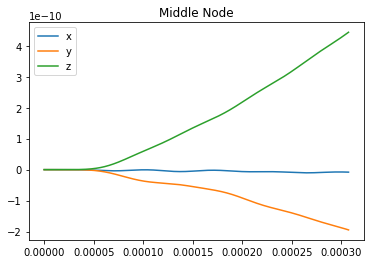

In [23]:
vxDisplacement = [0]
vyDisplacement = [0]
vzDisplacement = [0]

Times = np.linspace(0, len(MSignal), num=len(MSignal)+1)
Times *= ts

for i in range(len(MSignal)):
    vxDisplacement.append(vxDisplacement[i-1]+MSignal[i][0] * ts)
    vyDisplacement.append(vyDisplacement[i-1]+MSignal[i][1] * ts)
    vzDisplacement.append(vzDisplacement[i-1]+MSignal[i][2] * ts)

plt.clf()
plt.title('Middle Node')
plt.plot(Times,vxDisplacement,label='x')
plt.plot(Times,vyDisplacement,label='y')
plt.plot(Times,vzDisplacement,label='z')
plt.legend()
plt.savefig(imFolder+runName+'DisplaceMid.png')
#plt.show()

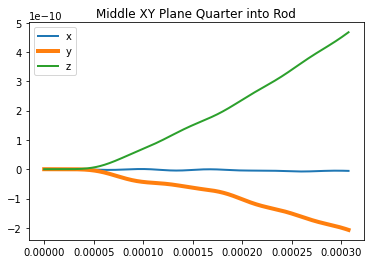

In [24]:
vxDisplacement = [0]
vyDisplacement = [0]
vzDisplacement = [0]

for i in range(len(FSignal)):
    vxDisplacement.append(vxDisplacement[i-1]+FSignal[i][0] * ts)
    vyDisplacement.append(vyDisplacement[i-1]+FSignal[i][1] * ts)
    vzDisplacement.append(vzDisplacement[i-1]+FSignal[i][2] * ts)

plt.clf()
plt.title('Middle XY Plane Quarter into Rod')
plt.plot(Times,vxDisplacement,label='x', linewidth=2)
plt.plot(Times,vyDisplacement,label='y', linewidth=4)
plt.plot(Times,vzDisplacement,label='z', linewidth=2)
plt.legend()
plt.savefig(imFolder+runName+'DisplaceFront.png')
plt.show()

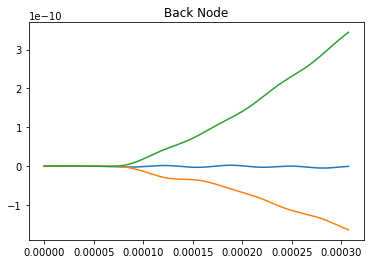

In [25]:
vxDisplacement = [0]
vyDisplacement = [0]
vzDisplacement = [0]

for i in range(len(BSignal)):
    vxDisplacement.append(vxDisplacement[i-1]+BSignal[i][0] * ts)
    vyDisplacement.append(vyDisplacement[i-1]+BSignal[i][1] * ts)
    vzDisplacement.append(vzDisplacement[i-1]+BSignal[i][2] * ts)

plt.clf()
plt.title('Back Node')
plt.plot(Times,vxDisplacement)
plt.plot(Times,vyDisplacement)
plt.plot(Times,vzDisplacement)
plt.savefig(imFolder+runName+'DisplaceBack.png')

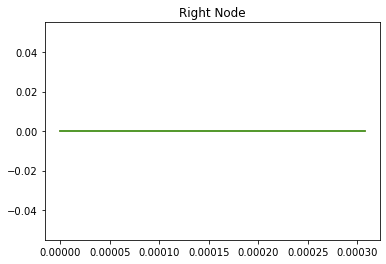

In [26]:
vxDisplacement = [0]
vyDisplacement = [0]
vzDisplacement = [0]

for i in range(len(RSignal)):
    vxDisplacement.append(vxDisplacement[i-1]+RSignal[i][0] * ts)
    vyDisplacement.append(vyDisplacement[i-1]+RSignal[i][1] * ts)
    vzDisplacement.append(vzDisplacement[i-1]+RSignal[i][2] * ts)

plt.clf()
plt.title('Right Node')
plt.plot(Times,vxDisplacement)
plt.plot(Times,vyDisplacement)
plt.plot(Times,vzDisplacement)
plt.savefig(imFolder+runName+'DisplaceRight.png')

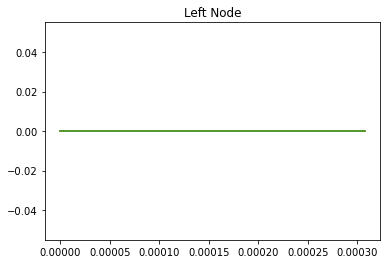

In [27]:
vxDisplacement = [0]
vyDisplacement = [0]
vzDisplacement = [0]

for i in range(len(LSignal)):
    vxDisplacement.append(vxDisplacement[i-1]+LSignal[i][0] * ts)
    vyDisplacement.append(vyDisplacement[i-1]+LSignal[i][1] * ts)
    vzDisplacement.append(vzDisplacement[i-1]+LSignal[i][2] * ts)

plt.clf()
plt.title('Left Node')
plt.plot(Times,vxDisplacement)
plt.plot(Times,vyDisplacement)
plt.plot(Times,vzDisplacement)
plt.savefig(imFolder+runName+'DisplaceLeft.png')

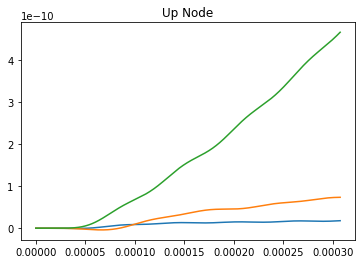

In [28]:
vxDisplacement = [0]
vyDisplacement = [0]
vzDisplacement = [0]

for i in range(len(USignal)):
    vxDisplacement.append(vxDisplacement[i-1]+USignal[i][0] * ts)
    vyDisplacement.append(vyDisplacement[i-1]+USignal[i][1] * ts)
    vzDisplacement.append(vzDisplacement[i-1]+USignal[i][2] * ts)

plt.clf()
plt.title('Up Node')
plt.plot(Times,vxDisplacement)
plt.plot(Times,vyDisplacement)
plt.plot(Times,vzDisplacement)
plt.savefig(imFolder+runName+'DisplaceUp.png')

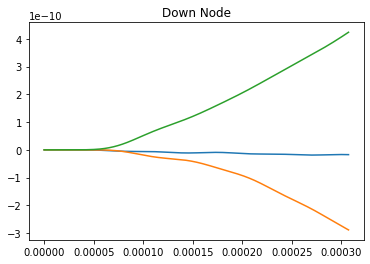

In [29]:
vxDisplacement = [0]
vyDisplacement = [0]
vzDisplacement = [0]

for i in range(len(DSignal)):
    vxDisplacement.append(vxDisplacement[i-1]+DSignal[i][0] * ts)
    vyDisplacement.append(vyDisplacement[i-1]+DSignal[i][1] * ts)
    vzDisplacement.append(vzDisplacement[i-1]+DSignal[i][2] * ts)

plt.clf()
plt.title('Down Node')
plt.plot(Times,vxDisplacement)
plt.plot(Times,vyDisplacement)
plt.plot(Times,vzDisplacement)
plt.savefig(imFolder+runName+'DisplaceDown.png')

In [30]:
#Data = [MSignal,USignal,DSignal,LSignal,RSignal,FSignal,BSignal]
print(np.shape(MSignal), np.shape(np.asarray(MSignal)))


(680, 3) (680, 3)


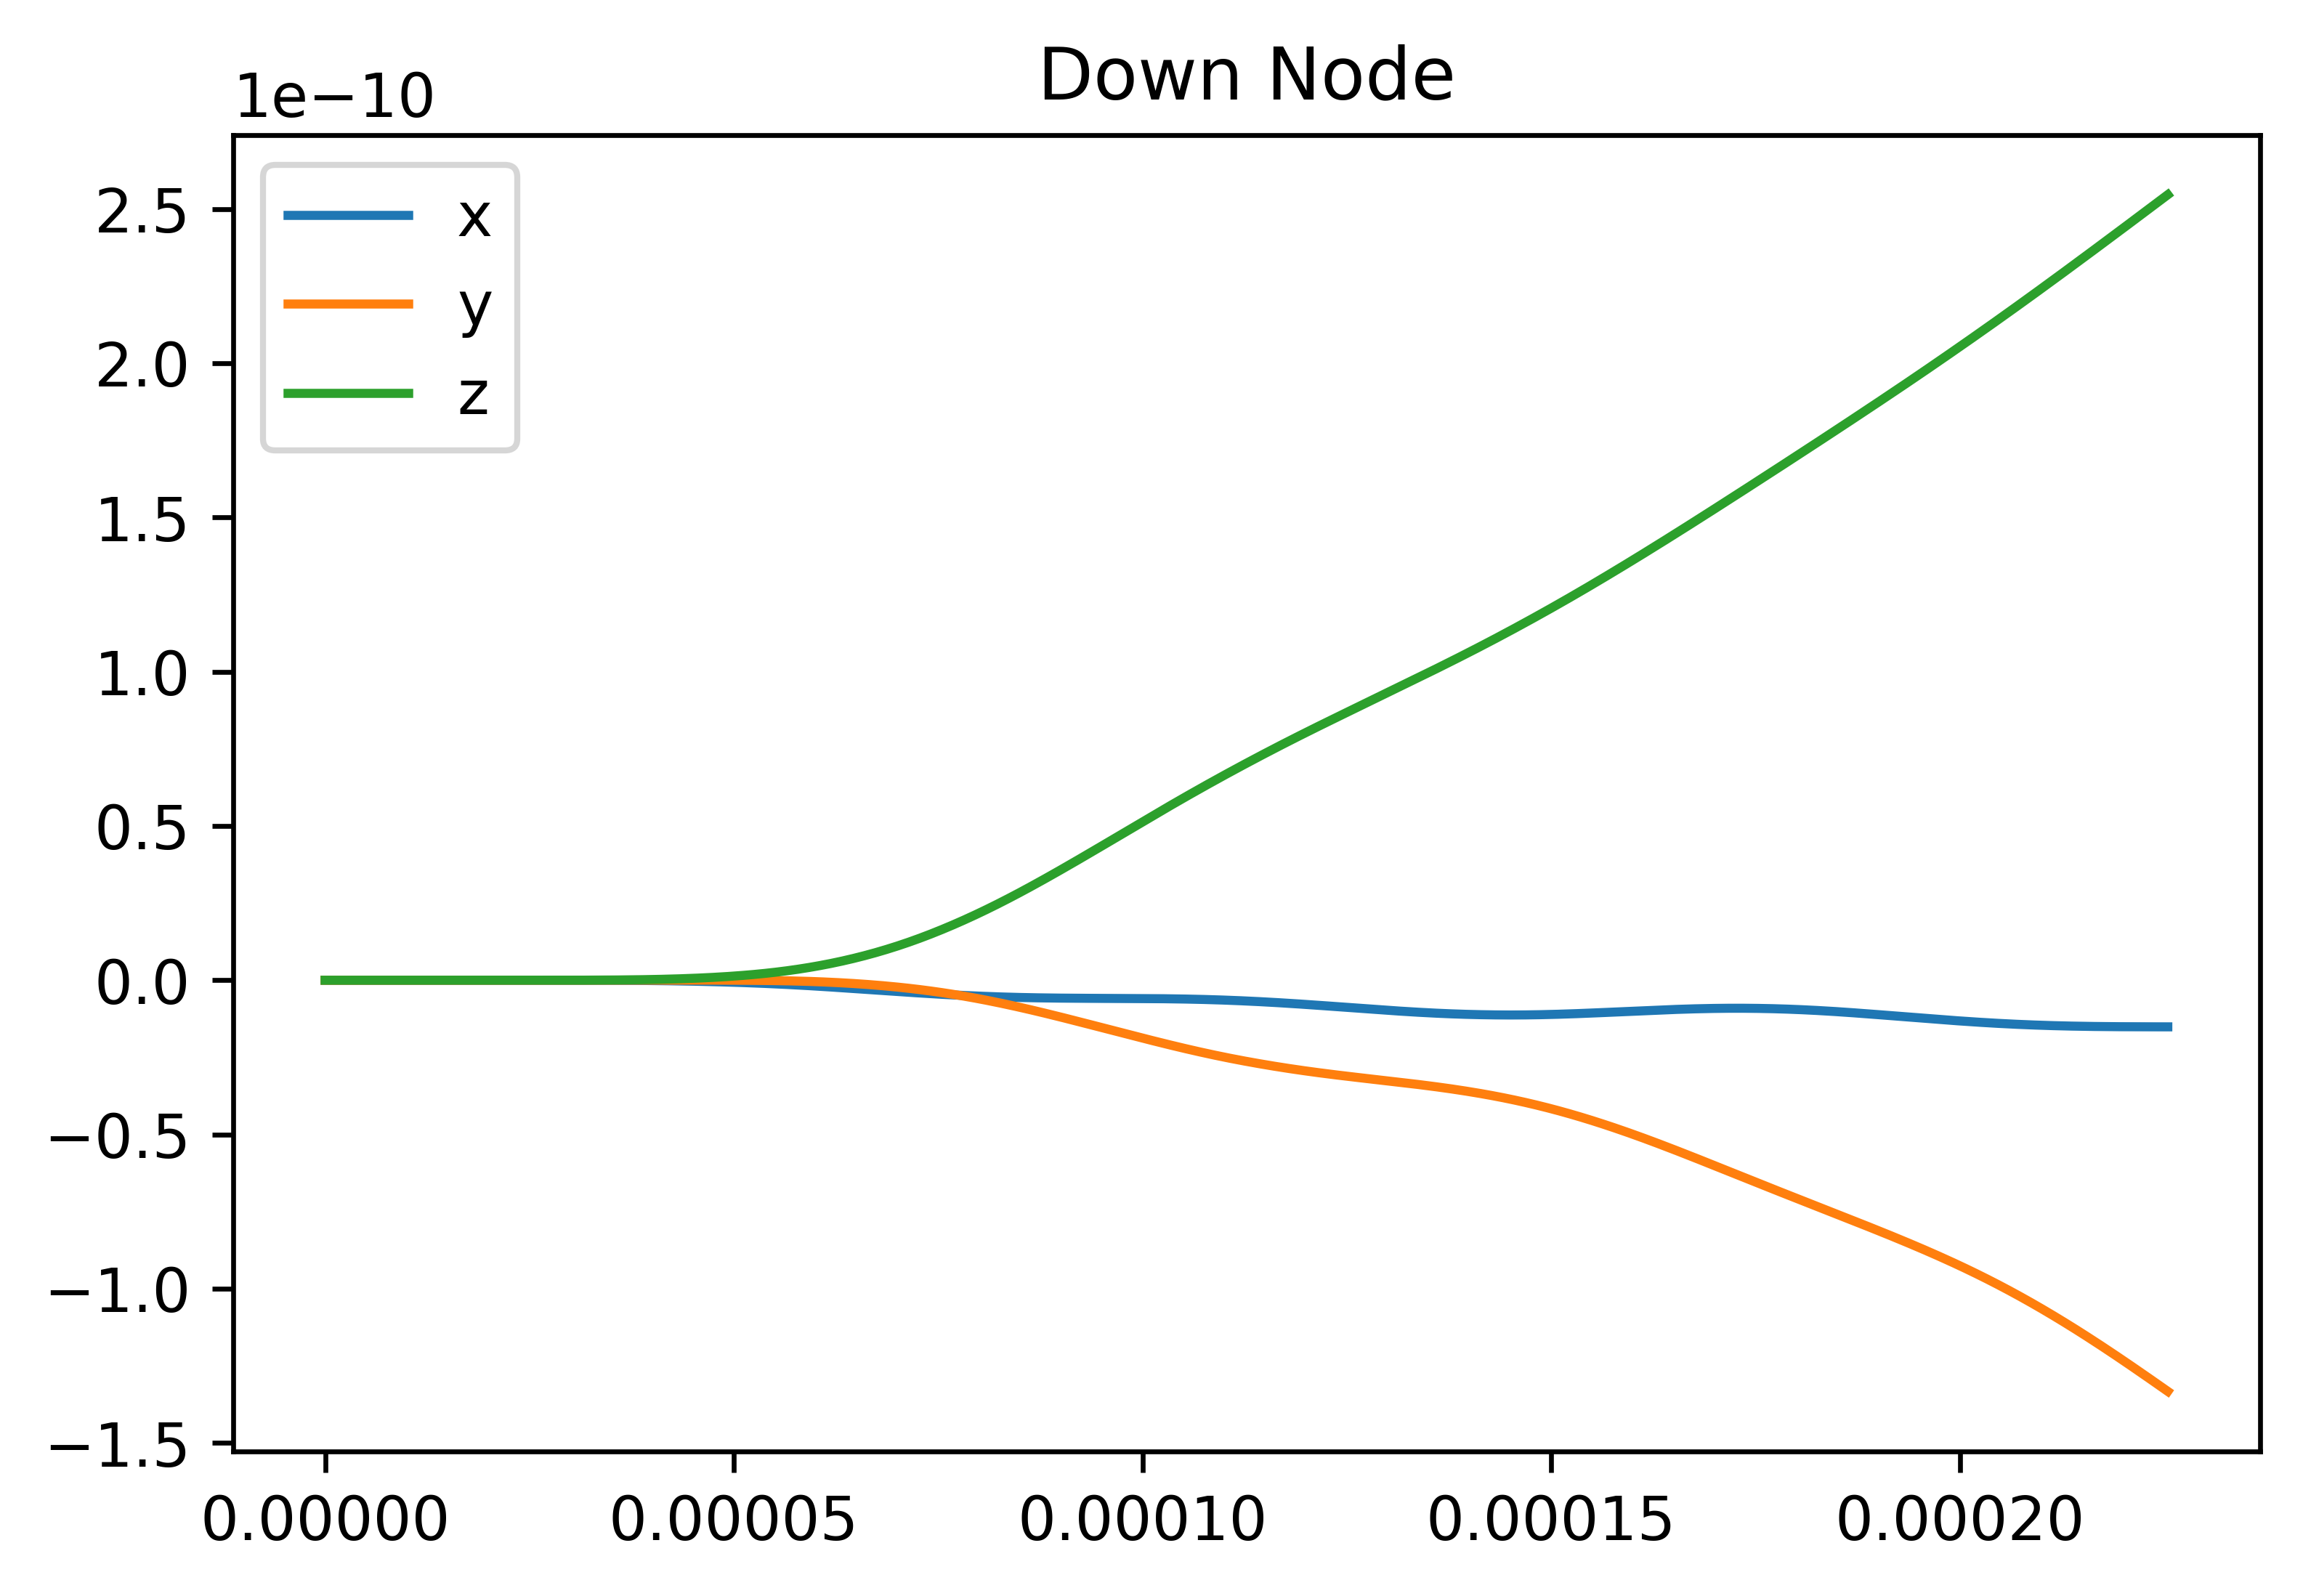

In [31]:
fig = plt.figure(dpi=600)
endnode=500
plt.clf()
plt.title('Down Node')
plt.plot(Times[:endnode],vxDisplacement[:endnode],label='x')
plt.plot(Times[:endnode],vyDisplacement[:endnode],label='y')
plt.plot(Times[:endnode],vzDisplacement[:endnode],label='z')
plt.legend()
plt.savefig(imFolder+runName+'DisplaceMid2.png')
plt.show()

In [32]:
Cases = ['PlaneWave']    #'SideRub','TopHit', 'Cube', 'CubeS'
Views = ['Mid', 'Vert','Head','zplane25','zplane75']

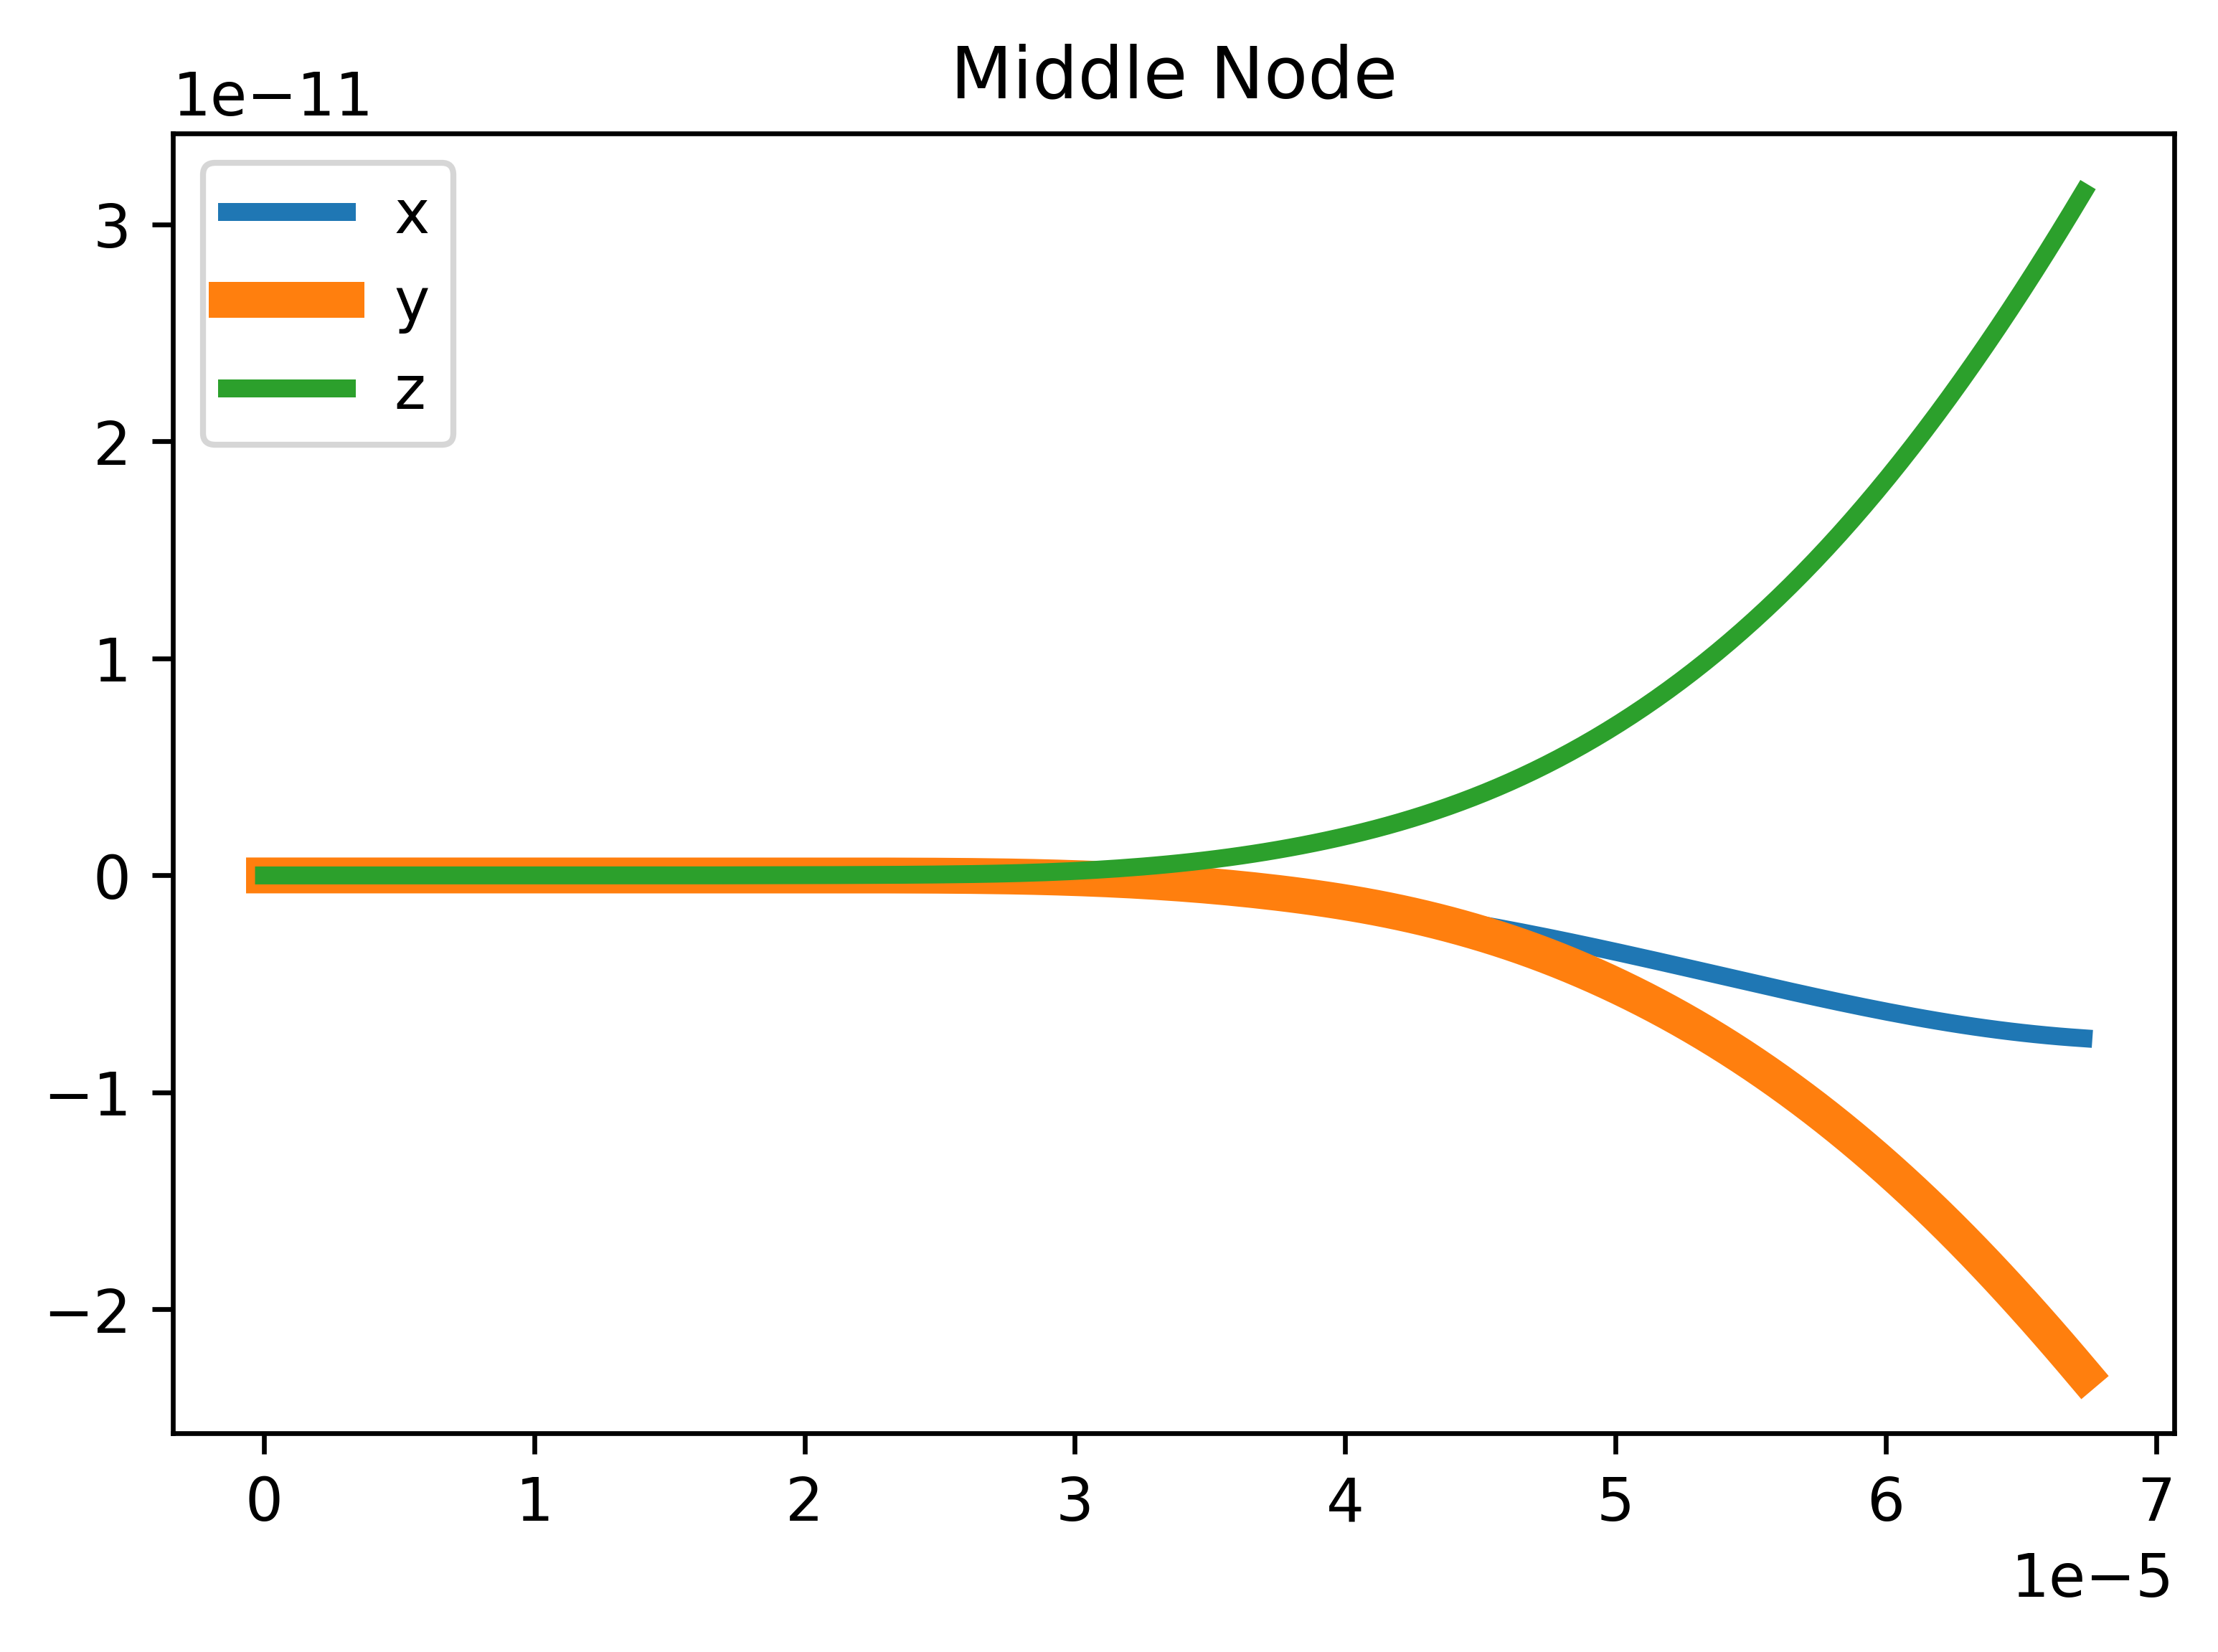

In [33]:
Displacement = np.zeros(np.shape(MSignal))

for i in range(np.shape(MSignal)[1]):
    for j in range(np.shape(MSignal)[0]):
        if j == 0:
            Displacement[j,i]=MSignal[j,i]*ts
        else:
            Displacement[j,i]=Displacement[j-1,i]+MSignal[j,i]*ts
    
fig = plt.figure(dpi=600)
endnode=150
plt.clf()
plt.title('Middle Node')
plt.plot(Times[:endnode],Displacement[:endnode,0],label='x', linewidth = 3)
plt.plot(Times[:endnode],Displacement[:endnode,1],label='y', linewidth = 6)
plt.plot(Times[:endnode],Displacement[:endnode,2],label='z', linewidth = 3)
plt.legend()
plt.savefig(imFolder+runName+'DisplaceMid2.png')
plt.show()

In [34]:
MidDisplaceX = np.zeros(np.shape(MidMatrixX))
MidDisplaceY = np.zeros(np.shape(MidMatrixY))
MidDisplaceZ = np.zeros(np.shape(MidMatrixZ))


In [35]:
for i in range(np.shape(MidMatrixX)[0]):
    for j in range(np.shape(MidMatrixX)[1]):
        if j == 0:
            MidDisplaceX[i,j]=MidMatrixX[i,j]*ts
            MidDisplaceY[i,j]=MidMatrixY[i,j]*ts
            MidDisplaceZ[i,j]=MidMatrixZ[i,j]*ts
        else:
            MidDisplaceX[i,j]=MidDisplaceX[i,j-1]+MidMatrixX[i,j]*ts
            MidDisplaceY[i,j]=MidDisplaceY[i,j-1]+MidMatrixY[i,j]*ts
            MidDisplaceZ[i,j]=MidDisplaceZ[i,j-1]+MidMatrixZ[i,j]*ts
            

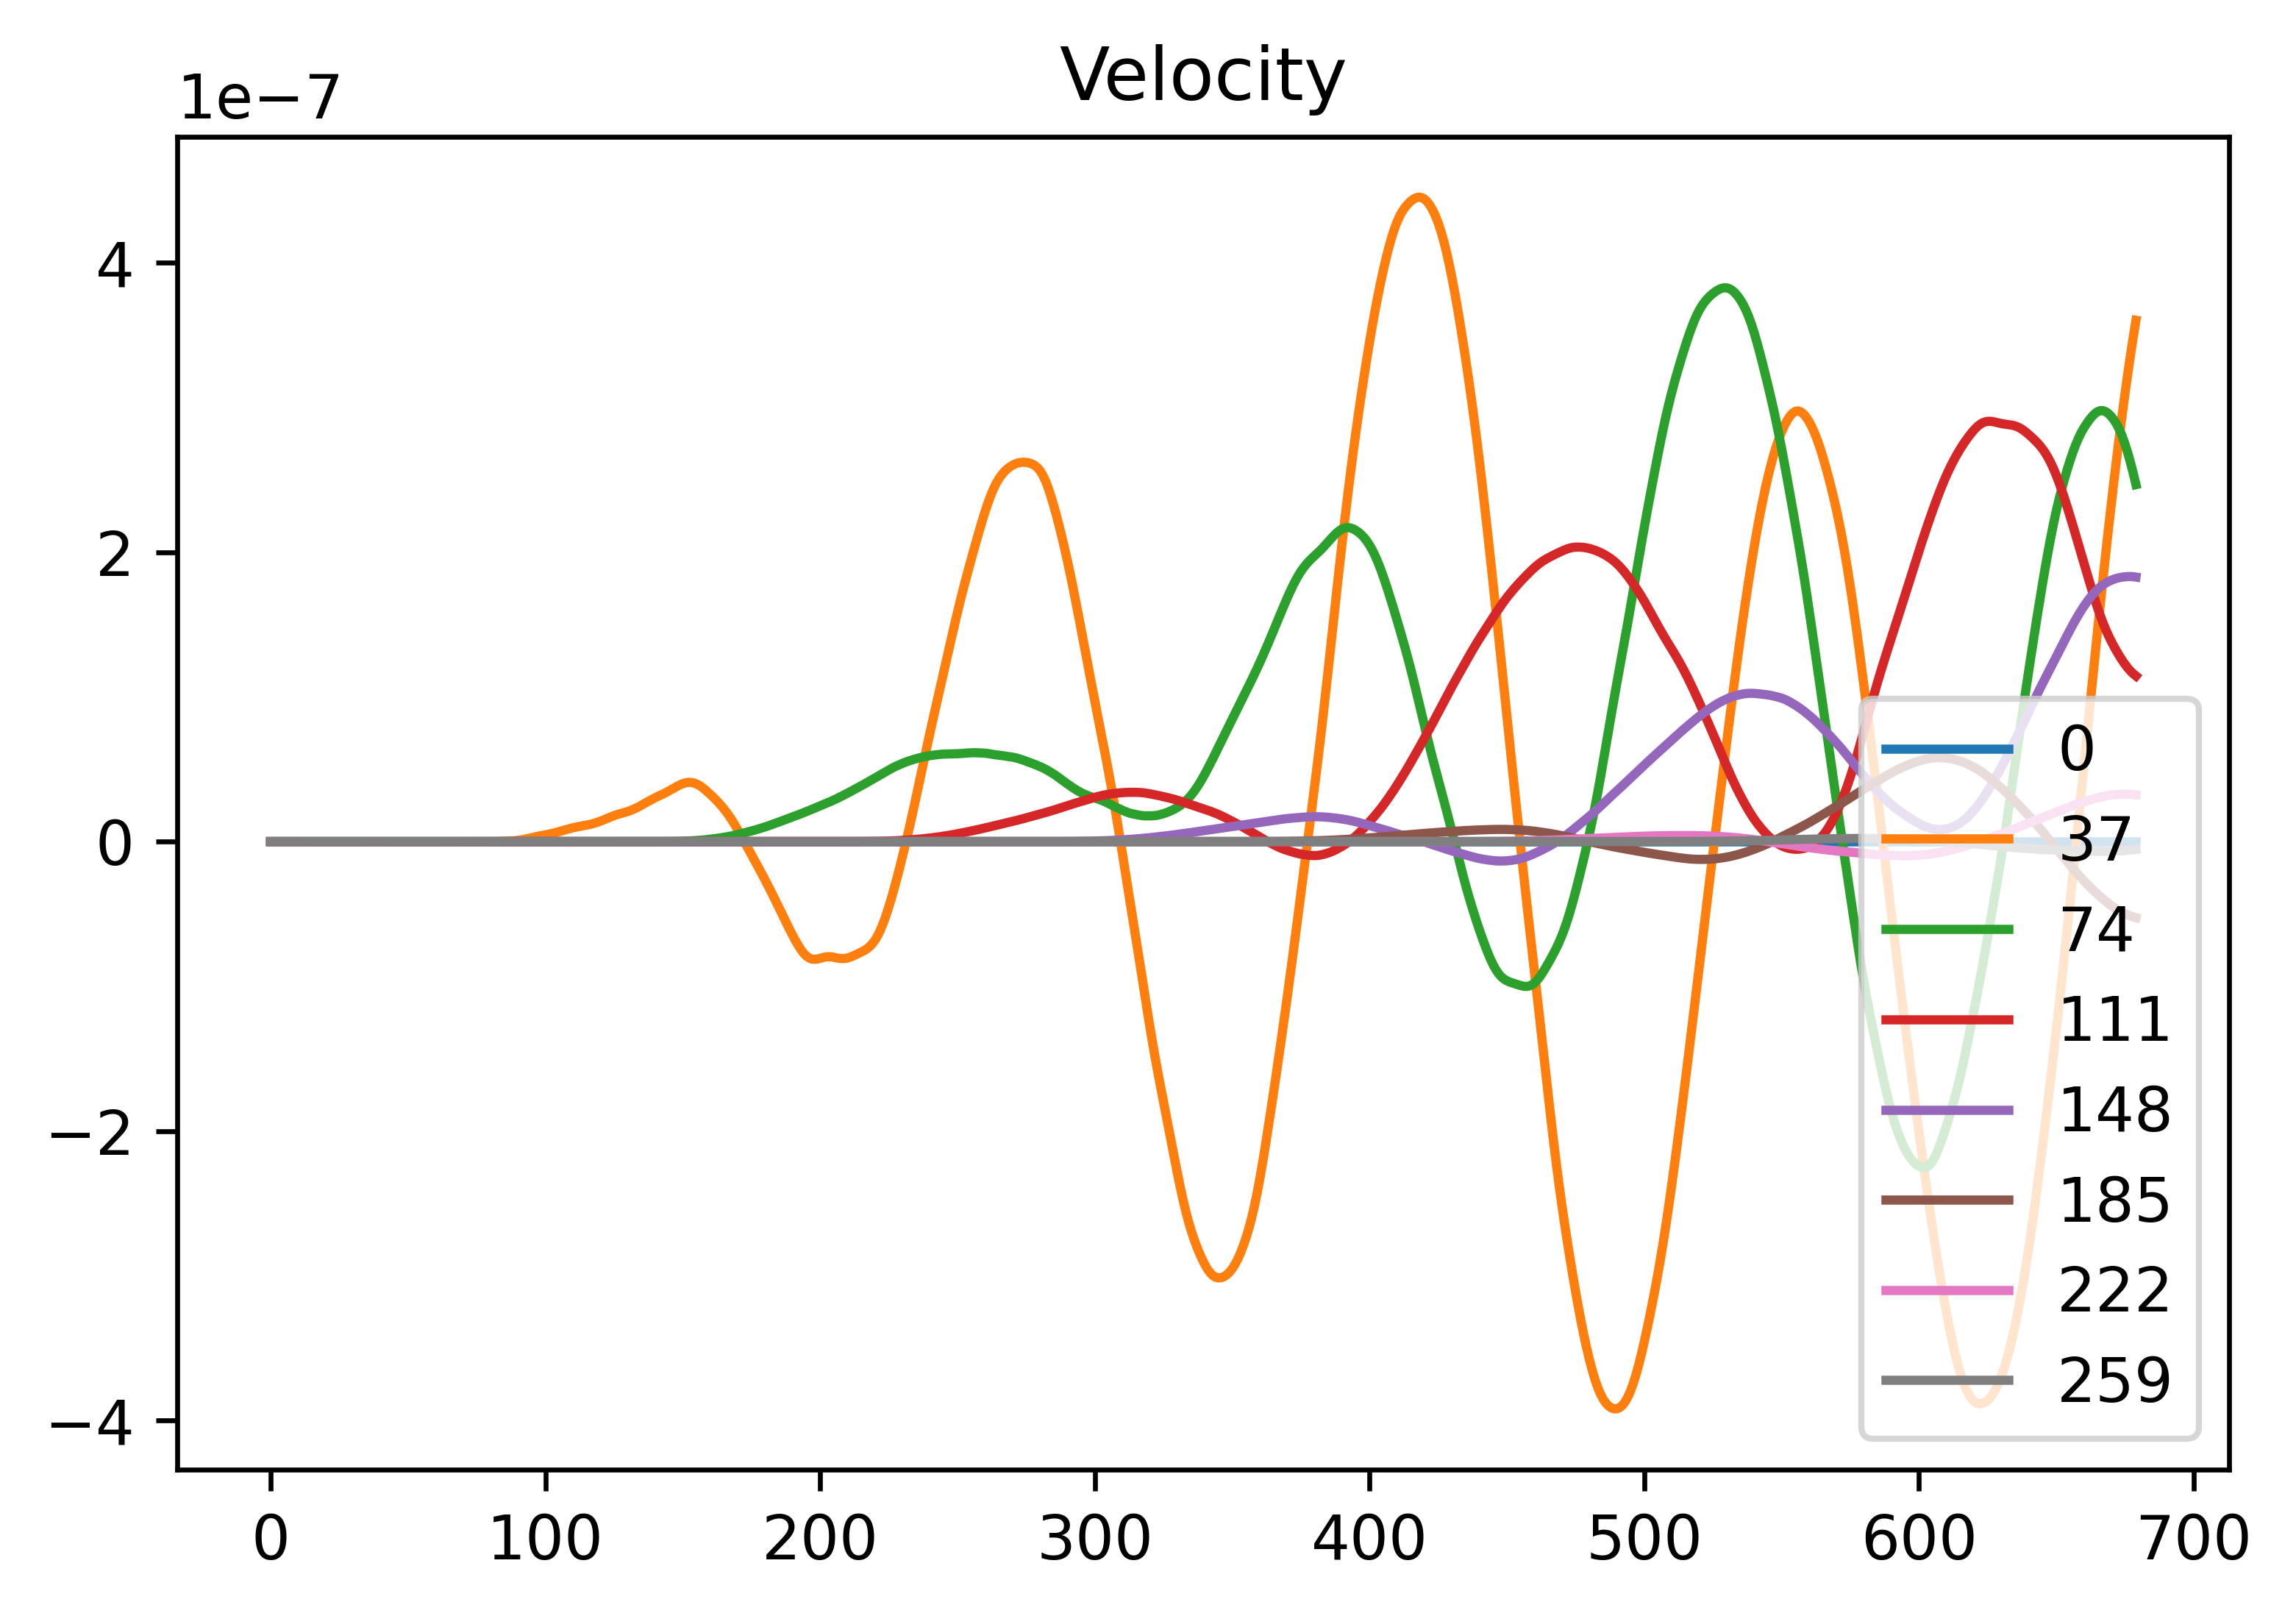

In [36]:
pts = 8
rng = int(gl1/pts)-1

fig = plt.figure(dpi=600, figsize=(6,4))
for i in range(pts):
    plt.plot(MidMatrixX[i*rng,:],label=str(i*rng))
plt.title('Velocity')
plt.legend()
plt.savefig(imFolder+runName+'MidVelocities.png')
plt.show()

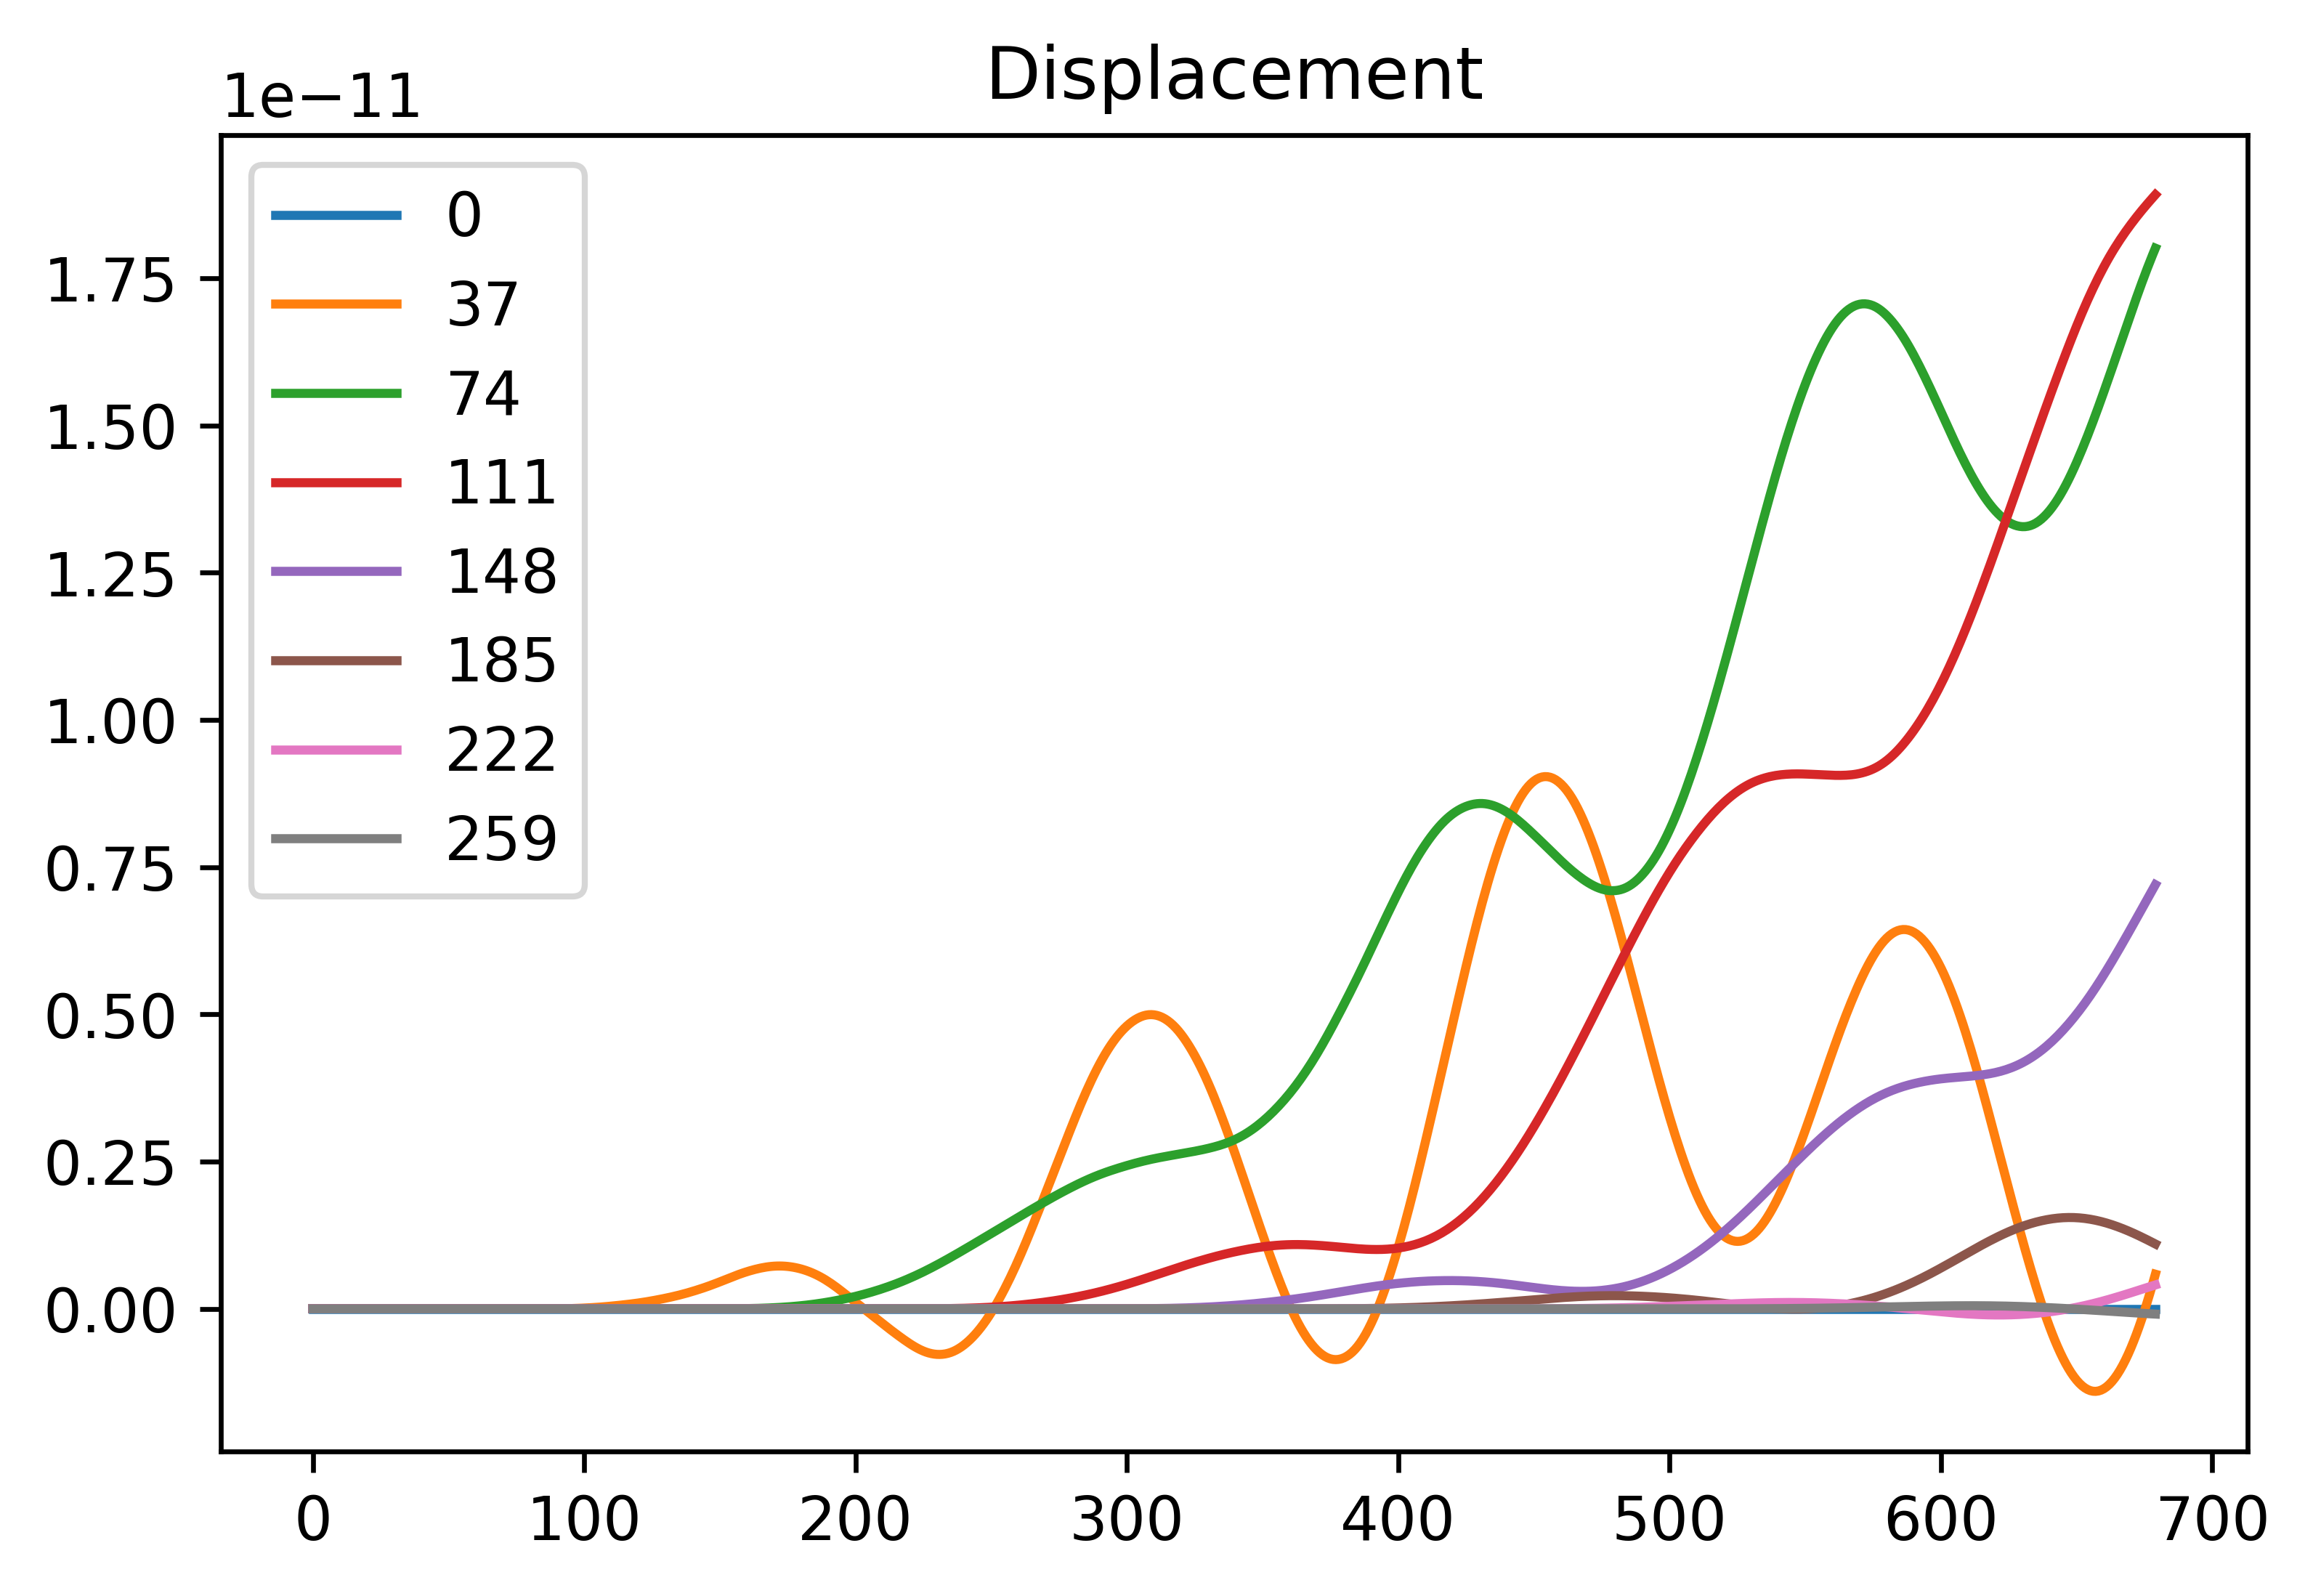

In [37]:
fig = plt.figure(dpi=600, figsize=(6,4))
for i in range(pts):
    plt.plot(MidDisplaceX[i*rng,:],label=str(i*rng))
plt.legend()
plt.title('Displacement')
plt.savefig(imFolder+runName+'MidDisplacementsX.png')
plt.show()

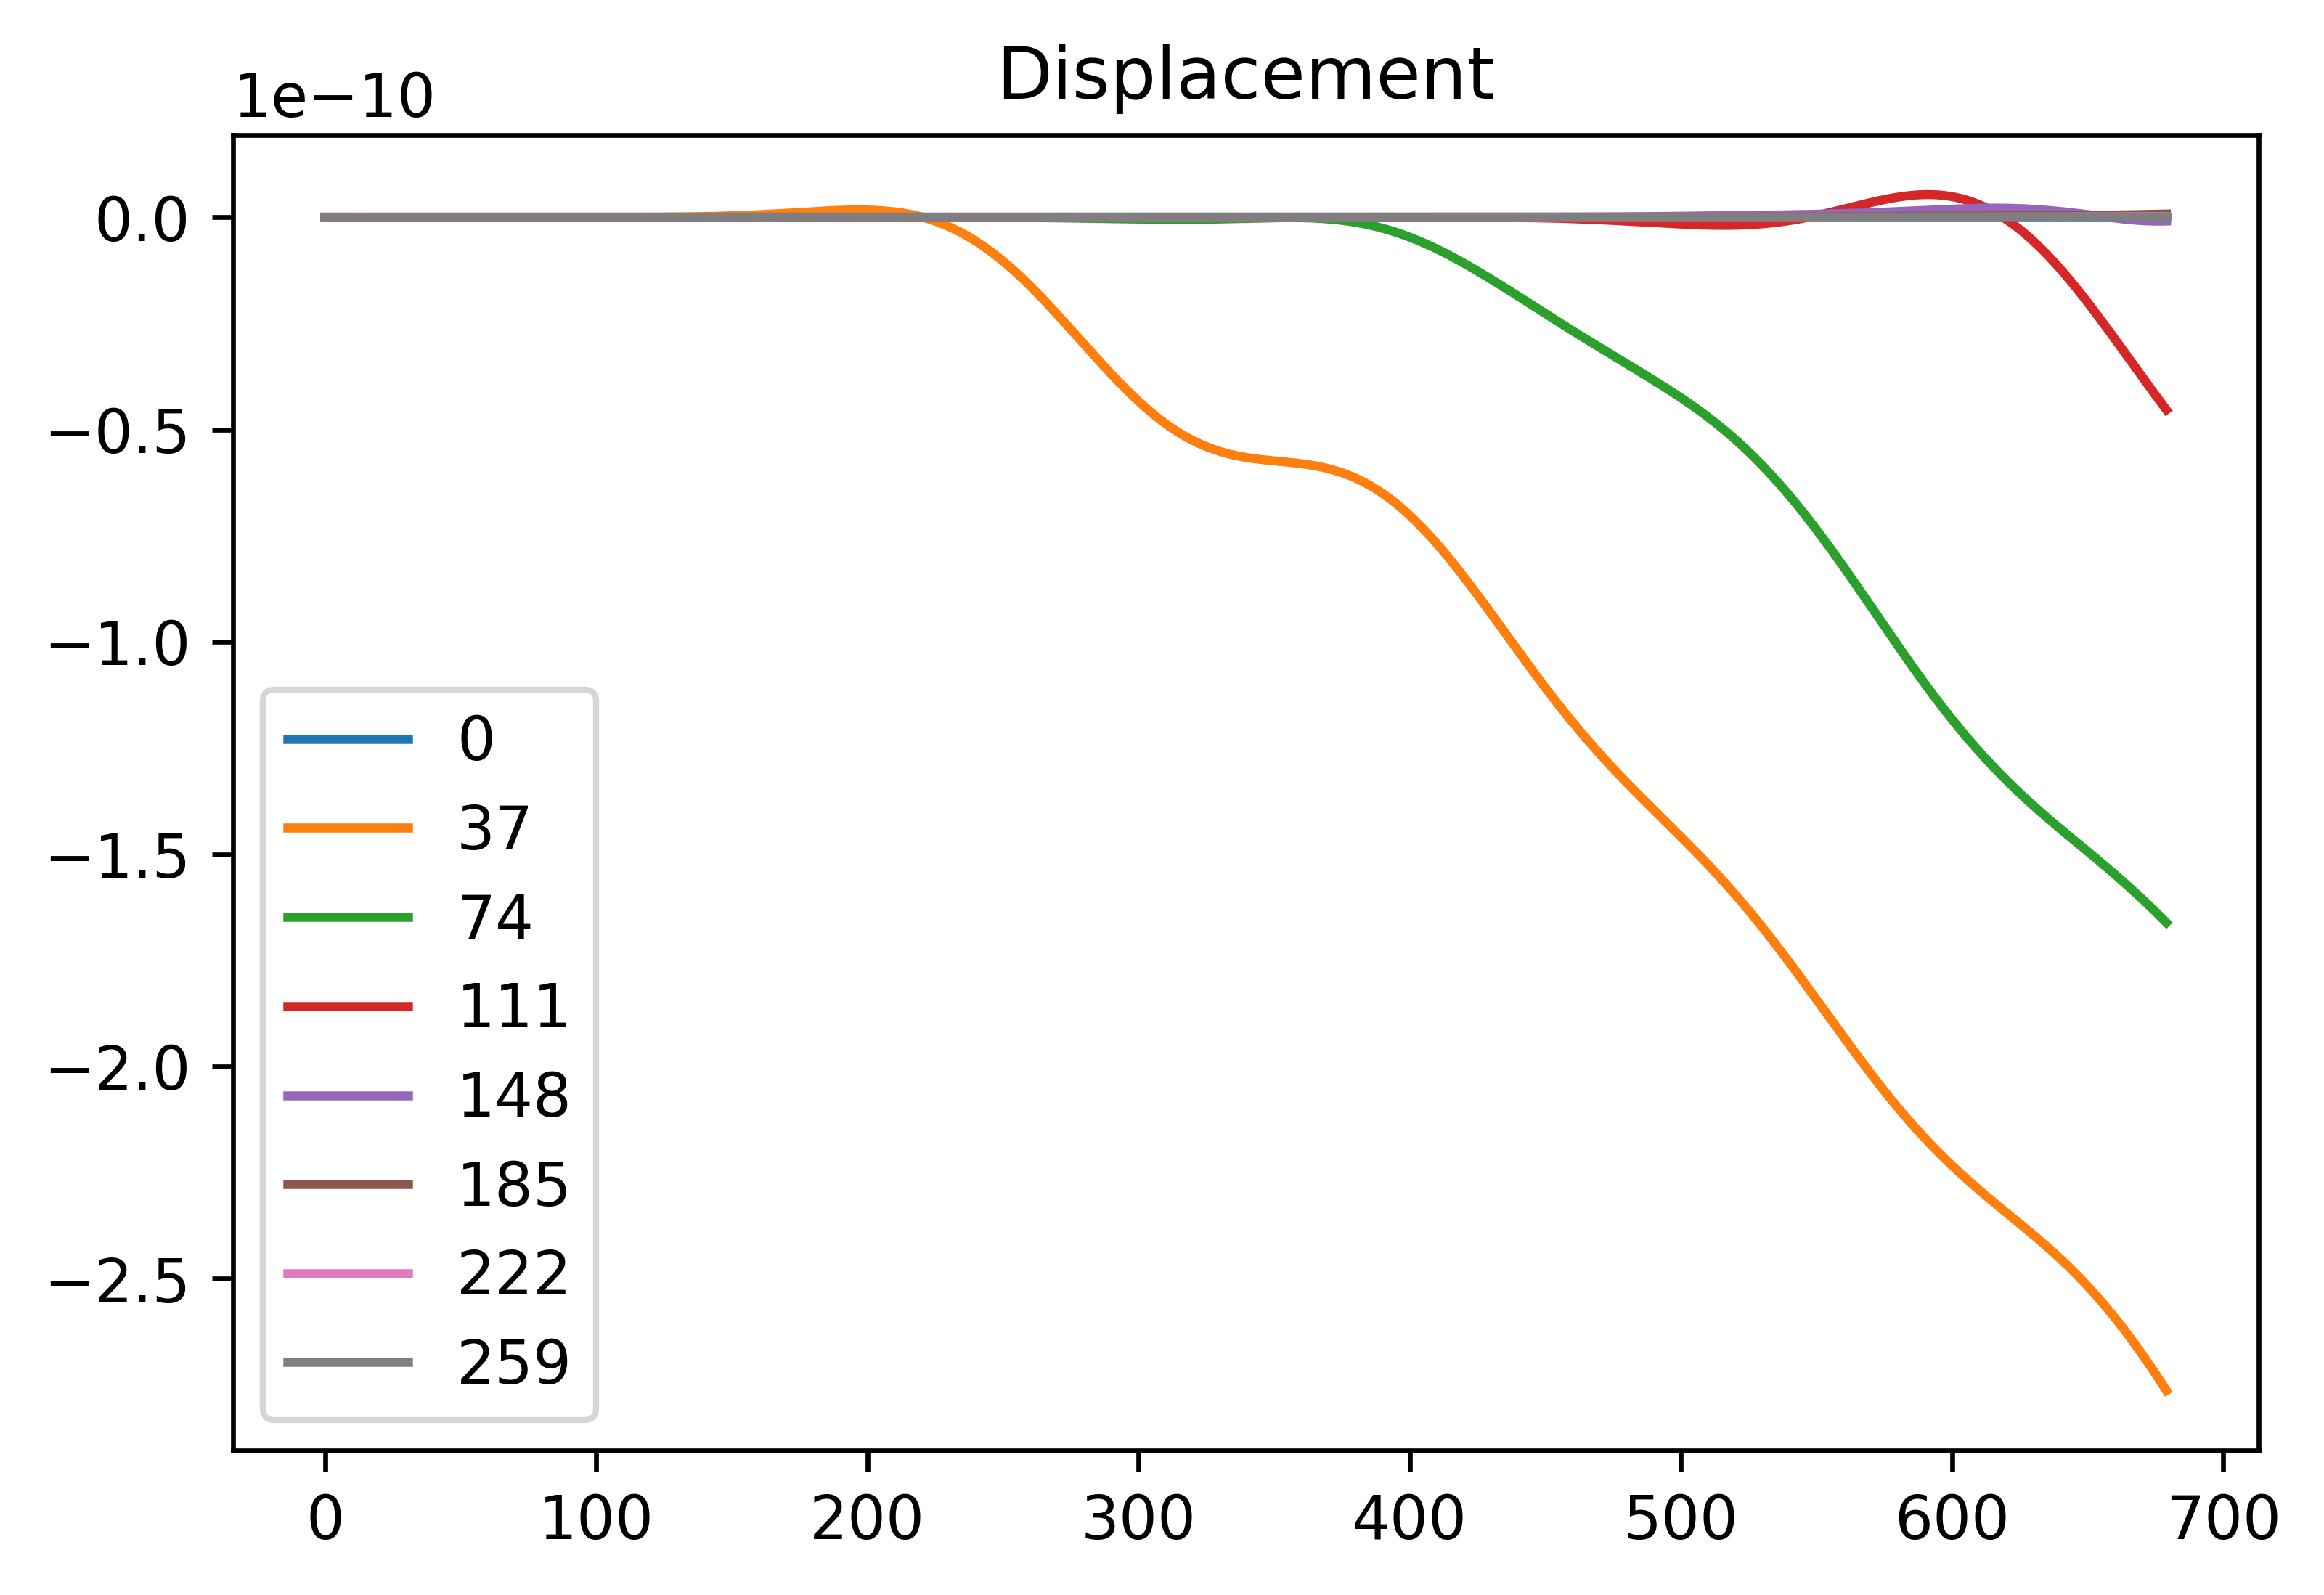

In [38]:
fig = plt.figure(dpi=600, figsize=(6,4))
for i in range(pts):
    plt.plot(MidDisplaceY[i*rng,:],label=str(i*rng))
plt.legend()
plt.title('Displacement')
plt.savefig(imFolder+runName+'MidDisplacementsY.png')
plt.show()

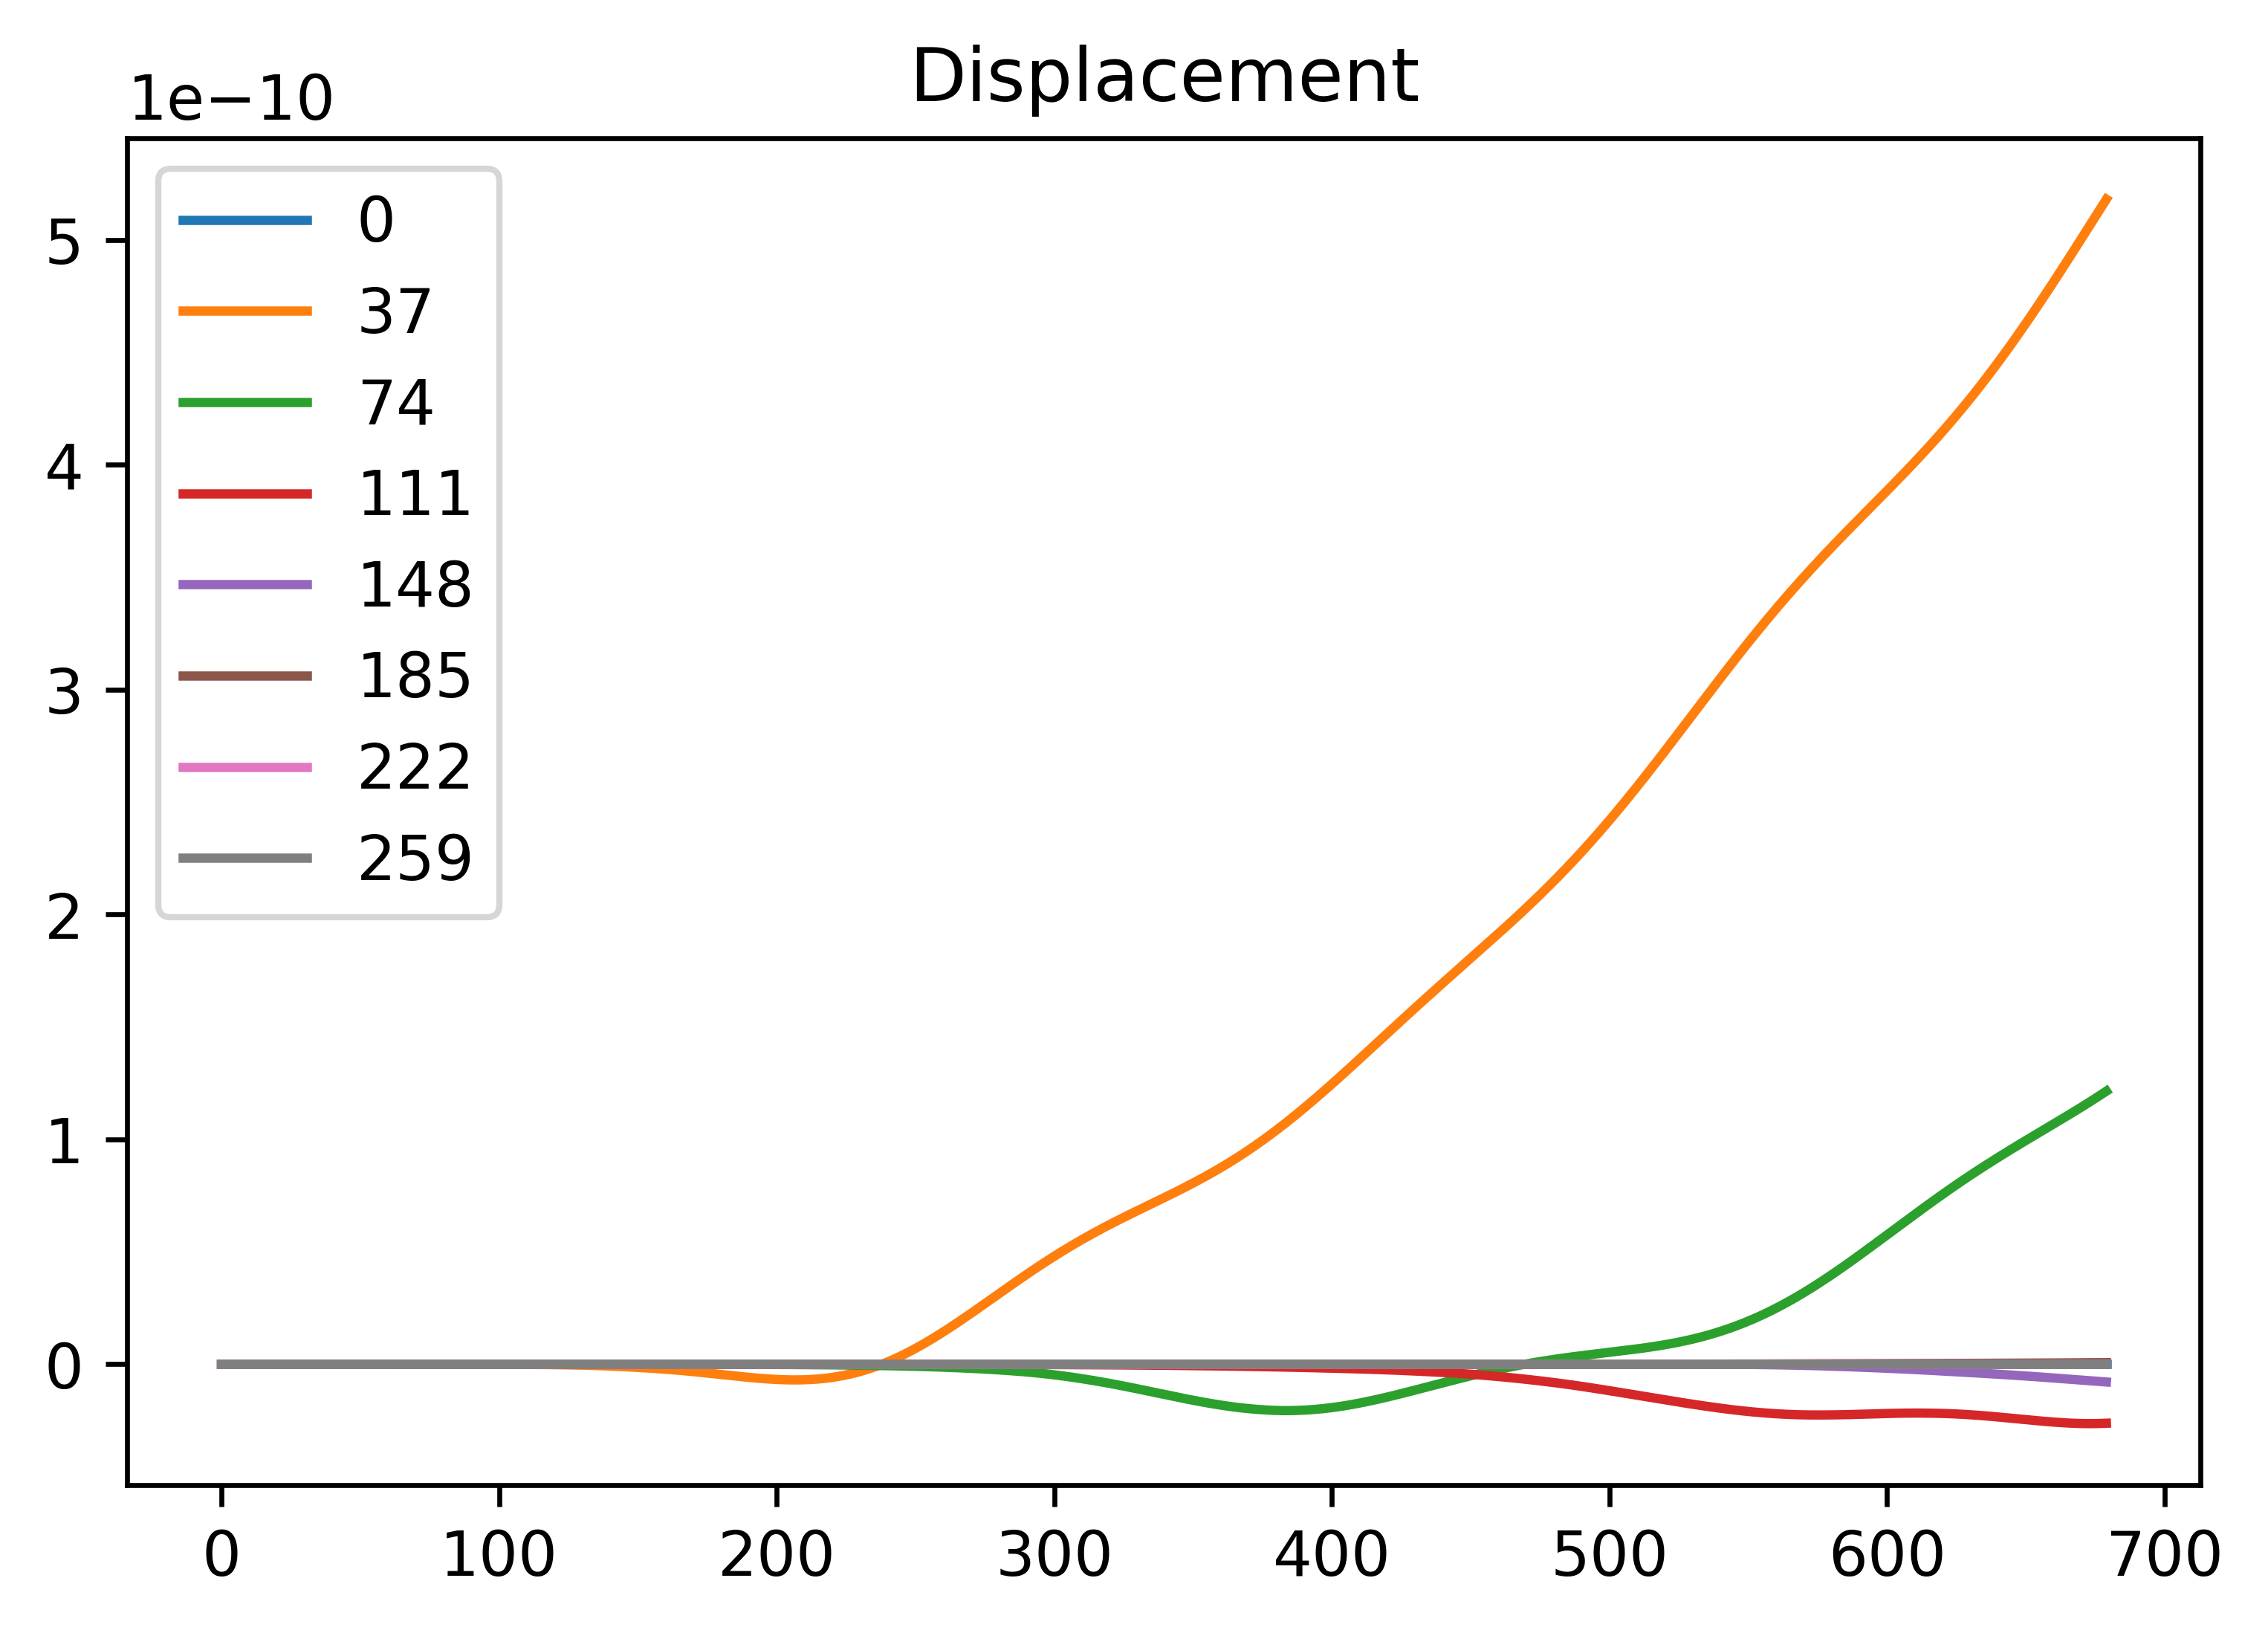

In [39]:
fig = plt.figure(dpi=600, figsize=(6,4))
for i in range(pts):
    plt.plot(MidDisplaceZ[i*rng,:],label=str(i*rng))
plt.legend()
plt.title('Displacement')
plt.savefig(imFolder+runName+'MidDisplacementsZ.png')
plt.show()

In [40]:
import multiprocessing
from joblib import Parallel, delayed
num_jobs=19

In [41]:
def EnergyFig(t, xStart, xEnd, yStart, yEnd, zStart, zEnd, Folder, v, figH):
    
    fig = plt.figure(figsize=(6,figH), dpi=300)
    
    Image = Movements[xStart:xEnd, yStart:yEnd, zStart:zEnd,t].T
    
    x,y,z = np.shape(Image)
    if x ==1:
        I2 = np.squeeze(Image, axis=(0,))
    if y ==1:
        I2 = np.squeeze(Image, axis=(1,))
    if z ==1:
        I2 = np.squeeze(Image, axis=(2,))
    
    plt.contourf(I2, v, cmap=plt.cm.jet)
    plt.savefig(imFolder+Folder+'/Energy'+str(t).zfill(5)+'.png')
    plt.close(fig)

In [42]:
def AnimationBook(xStart, xEnd, yStart, yEnd, zStart, zEnd, Folder):

    if xStart - xEnd == 0.0:
        figH = 6 * (yEnd - yStart) / (zEnd-zStart)
        xEnd+=1
    elif yStart - yEnd == 0.0:
        figH = 6 * (zEnd - zStart) / (xEnd-xStart)
        yEnd+=1
    elif zStart - zEnd == 0.0:
        figH = 6 * (yEnd - yStart) / (xEnd-xStart)
        zEnd+=1
    else:
        figH = 0

    if figH==0:
        print("Error, no Dimmension is a plane",yStart-yEnd)
    else:
        EMin = np.min(Movements[xStart:xEnd, yStart:yEnd, zStart:zEnd,:])
        EMax = np.max(Movements[xStart:xEnd, yStart:yEnd, zStart:zEnd,:])
        v = np.linspace(EMin, EMax, 30, endpoint=True)[0:20]

        temp = Parallel(n_jobs=num_jobs)(delayed(EnergyFig)(t, xStart, xEnd, yStart, yEnd, zStart, zEnd, Folder,v,figH) for t in range(Tsteps))
        
        


In [43]:
plt.close('all')
AnimationBook(0,xmax,gridEndWeb-1,gridEndWeb-1,gridEndFoot,gridStartHead,"WebEnd")


In [44]:
plt.close('all')
AnimationBook(0,xmax,gridEndHeadWidth-1,gridEndHeadWidth-1,gridStartHead,zmax,"HeadEnd")


In [45]:
plt.close('all')
AnimationBook(0,xmax,gridStartHeadWidth,gridEndHeadWidth,zmax-3,zmax-3,"TopSurface")
plt.close('all')
AnimationBook(0,xmax,gridStartHeadWidth,gridStartHeadWidth,gridStartHead,zmax,"LeftSurface")
plt.close('all')
AnimationBook(0,xmax,gridStartWeb,gridStartWeb,gridEndFoot,gridStartHead,"RightSurface")
plt.close('all')
